## Nonlinear MPC with Kinematic Bicycle Model

The bicycle model is the same one used in <a href=https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1#Tab4>this paper (Figure 3)</a>

The model has state and input:
\begin{gather*}
z = \begin{bmatrix}x\\ y\\ v\\ \psi\end{bmatrix},\quad
u = \begin{bmatrix}a\\ \delta_f\end{bmatrix},\quad
\end{gather*}

The 4 states are:
* $x$ and $y$, the car's position in the world frame
* $v$, the car's velocity
* $\psi$, the angle of the car's centerline in the world frame


The two control signals are $a$, the acceleration command, and $\delta_f$, the front steering angle (in radians).

$\beta$ is the angle between the car's centerline and its velocity vector. It is not really a state, but a function of $\delta_f$.

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


## Casadi setup
From http://casadi.sourceforge.net/v3.4.4/users_guide/casadi-users_guide.pdf

In [1]:
# Library dependencies
import casadi
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import bezier

# Local dependencies
from direct_collocation  import MpcProblem
from KinematicBicycleCar import KinematicBicycleCar

#from direct_collocation_opti  import MpcProblem
#from KinematicModel  import KinematicBicycle

from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

from road                import iso_double_lane_change as test_road
test_road_width = 5.0*np.ones(np.size(test_road)//2)
#from complex_track_2                import complex_track_2 as test_road
#from complex_track_2                import complex_track_2_width as test_road_width
#from road_with_obstruction import road_with_obstruction as test_road
#from road_with_obstruction import road_with_obstruction_width as test_road_width

# Generates a totally straight test_road
#test_road = np.empty((100,2))
#for i in range(100):
#    test_road[i,0] = i
#    test_road[i,1] = -0.001*i if i > 60 else 0.001*i

# Flips the test road, so the car goes from the end to the start.
#test_road = np.flip(test_road, 0)


## Initialize the car and road model

In [2]:
# Initialize the car model with 0.075 second steps and 30 step lookahead
car = KinematicBicycleCar(N=30, step=0.075)
DESIRED_SPEED = 5.0
step = 0.075
N = 30

In [3]:
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time

 [ 0.]] is [15.28968758] away at s = 0.012034637828942558, B(s) = [[9.96891533e+00]
 [1.83244721e-17]]
 [ 0.]] is [15.72259511] away at s = 0.02457308184468577, B(s) = [[2.00139878e+01]
 [1.77563205e-12]]
 [ 0.]] is [14.52614119] away at s = 0.03849461062298814, B(s) = [[3.00576112e+01]
 [1.75676151e-09]]
 [ 0.]] is [13.55609329] away at s = 0.05475452436113872, B(s) = [[3.99630405e+01]
 [2.95790905e-07]]
 [ 0.]] is [12.98917298] away at s = 0.06433647905010509, B(s) = [[4.50321205e+01]
 [2.75208340e-06]]
 [ 0.]] is [13.27543701] away at s = 0.07448072291292603, B(s) = [[4.99651086e+01]
 [1.92866944e-05]]
 [ 0.]] is [13.31075205] away at s = 0.08558755713960864, B(s) = [[5.50201211e+01]
 [1.13143616e-04]]
 [ 0.]] is [12.97499973] away at s = 0.09719331377081405, B(s) = [[6.00508873e+01]
 [5.28653028e-04]]
 [ 0.]] is [12.41360199] away at s = 0.10905299814632262, B(s) = [[6.50040919e+01]
 [1.98814312e-03]]
 [ 0.]] is [11.93208638] away at s = 0.12143317349514081, B(s) = [[6.99918889e+01

 [  0.   ]] is [4.83474546] away at s = 0.6618756656453533, B(s) = [[189.5876698 ]
 [  0.52711352]]
 [  0.   ]] is [4.72839428] away at s = 0.6728446957119234, B(s) = [[191.68414856]
 [  0.37887766]]
 [  0.   ]] is [4.49360117] away at s = 0.6871679998310471, B(s) = [[194.38637201]
 [  0.23374231]]
 [  0.   ]] is [4.06050471] away at s = 0.7028973627995656, B(s) = [[1.97255196e+02]
 [1.27716593e-01]]
 [  0.   ]] is [3.7041067] away at s = 0.7178239238235493, B(s) = [[1.99822588e+02]
 [6.64881067e-02]]
 [  0.   ]] is [3.13934664] away at s = 0.7357110965225526, B(s) = [[2.02627958e+02]
 [2.71399276e-02]]
 [  0.   ]] is [3.12527829] away at s = 0.8569614222900236, B(s) = [[2.15190236e+02]
 [3.63614839e-07]]
 [  0.]] is [2.99884034] away at s = 0.8553270185193984, B(s) = [[2.14990457e+02]
 [4.63947617e-07]]
 [  0.]] is [4.53690574] away at s = 0.8754363985533744, B(s) = [[2.18008284e+02]
 [1.72705841e-08]]
 [  0.]] is [6.46281843] away at s = 0.8928026868642858, B(s) = [[2.21972664e+02]
 

## Boundary functions
We represent the road boundaries as a series of polygons. At each step $x_k$, $x_{k+1},...,x_N$, the car's x-y position is bounded by a 4-sided polygon.
The polygons for successive states overlap, allowing the car to steer and slow down / speed up within the confines of the road.

This image shows 5 successive bounds from $k$ to $k+5$. The $k+5^{th}$ bound is in red.
![title](polygon_bounds.png)

In [4]:
# What we should do now
# 1. Use the velocity estimate to "step through" the road,
#    obtaining a set of road midpoints and constraint boundaries
# 2. Add a term to the cost function that attracts the successive states to the road midpoints - done
# 3. Use the midpoints to initialize the variable estimate so the solver is faster. - done,
#    and we are initializing the new control uk to the previously computed one
#    kind of warm-starting ipopt - done

## Run the MPC algorithm

In [5]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

def desired_speed(k:int):
    return DESIRED_SPEED

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]
car.set_initial(ic, desired_speed, roadrunner)
print("Starting at initial conditions", ic)

# This is the model:
# https://link-springer-com.stanford.idm.oclc.org/article/10.1007/s13177-020-00226-1/figures/3
mpcprob = MpcProblem(car, roadrunner,  )
#mpcprob = MpcProblem(KinematicBicycle("base_vehicle_model.json"),
#                                      roadrunner,step, N, desired_speed )

Starting at initial conditions [-59.03778965972378, 3.8347514317033546e-12, 5.0, 3.047821776979959e-12]


<IPython.core.display.Javascript object>


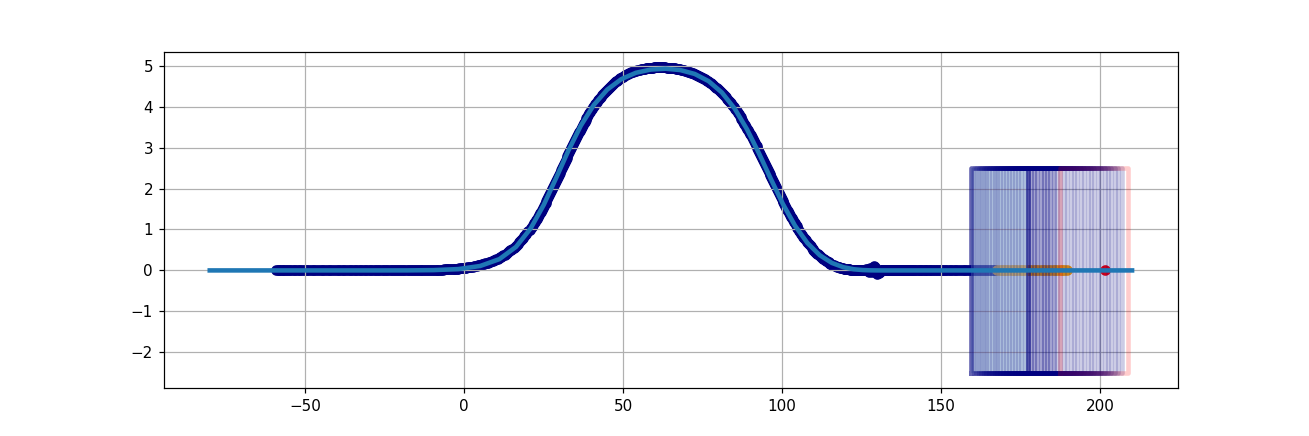


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equa

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  97  1.6770308e+03 9.24e-02 9.20e+01  -3.8 4.84e+01  -2.3 1.00e+00 1.05e-01f  1
  98  1.6948101e+03 8.71e-02 8.66e+01  -3.8 1.52e+02  -2.8 3.37e-02 6.09e-02h  1
  99  1.5912969e+03 6.65e-02 6.71e+01  -3.8 1.14e+03    -  4.30e-02 2.36e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5912518e+03 6.65e-02 6.71e+01  -3.8 1.42e+02  -3.3 2.38e-01 3.26e-04h  1
 101  1.5425117e+03 5.61e-02 6.49e+01  -3.8 7.24e+02    -  2.84e-02 1.57e-01f  1
 102  1.5315665e+03 5.65e-02 7.23e+01  -3.8 1.19e+04    -  3.66e-06 2.27e-03f  1
 103  1.5121338e+03 5.15e-02 8.07e+01  -3.8 5.58e+02    -  3.81e-01 8.92e-02f  1
 104  1.4897018e+03 4.88e-02 7.69e+01  -3.8 6.71e+02    -  2.59e-02 6.21e-02f  1
 105  1.4684873e+03 4.36e-02 6.89e+01  -3.8 3.74e+02    -  1.96e-01 1.05e-01f  1
 106  1.4391498e+03 3.81e-02 5.78e+01  -3.8 3.54e+02    -  3.32e-02 1.33e-01f  1
 107  1.4259226e+03 3.45e-02 5.23e+01  -3.8 2.51e+02    -  1.33e-01 9.54e-02f  1
 108  1.4003214e+03 3.03e-02

  52  1.3255115e+03 2.80e-03 1.60e+00  -1.0 4.60e+01  -3.9 1.00e+00 1.00e+00f  1
  53  1.2800695e+03 5.07e-03 1.20e+00  -1.0 7.42e+01  -4.4 1.00e+00 1.00e+00f  1
  54  1.2272101e+03 1.24e-02 8.31e-01  -1.0 1.26e+02  -4.9 1.00e+00 1.00e+00f  1
  55  1.1883229e+03 3.76e-02 1.16e+00  -1.7 1.95e+02  -5.4 4.47e-01 1.00e+00f  1
  56  1.1875204e+03 4.01e-02 1.04e+00  -1.7 4.01e+01  -4.0 2.38e-01 5.83e-02f  4
  57  1.1877121e+03 4.01e-02 1.03e+00  -1.7 7.02e+00  -1.8 2.99e-01 2.01e-02h  5
  58  1.2223371e+03 1.73e-02 4.36e+00  -1.7 1.48e+00  -0.5 1.00e+00 5.74e-01h  1
  59  1.2232510e+03 1.69e-02 4.84e+00  -1.7 4.46e-01  -0.0 1.00e+00 2.15e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  1.2165727e+03 1.44e-02 1.14e+01  -1.7 1.14e+00  -0.5 1.00e+00 1.19e-01F  1
  61  1.2355439e+03 1.31e-02 4.96e+01  -1.7 1.53e+00  -0.1 1.00e+00 8.72e-02h  1
  62  1.2747441e+03 3.59e-03 3.50e+01  -1.7 8.82e-01  -0.6 8.93e-01 7.26e-01H  1
  63  1.2572986e+03 2.33e-03

  51  1.0794215e+03 1.24e-07 6.40e-07  -3.8 4.38e+00    -  1.00e+00 1.00e+00h  1
  52  1.0794067e+03 7.99e-09 2.80e-03  -5.7 4.28e+00    -  1.00e+00 9.36e-01h  1
  53  1.0794057e+03 4.51e-13 1.84e-11  -5.7 6.75e-01    -  1.00e+00 1.00e+00f  1
  54  1.0794056e+03 1.59e-13 5.57e-07  -8.6 7.42e-02    -  1.00e+00 1.00e+00h  1
  55  1.0794055e+03 1.38e-13 2.51e-14  -8.6 4.02e-04    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:   5.7429224620142193e+01    1.0794055499358433e+03
Dual infeasibility......:   2.5059035596912821e-14    4.7099472922120364e-13
Constraint violation....:   1.3755663275105690e-13    1.3755663275105690e-13
Complementarity.........:   2.5076191268330945e-09    4.7131717701784525e-08
Overall NLP error.......:   2.5076191268330945e-09    4.7131717701784525e-08


Number of objective function evaluations             = 77
Number of objective gradient evaluations        

  69  1.5547525e+04 2.97e-02 2.12e+07  -1.0 2.11e+01   3.5 6.62e-01 1.15e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  1.6806739e+04 2.56e-02 2.31e+07  -1.0 2.15e+01   3.0 3.52e-01 1.38e-01h  1
  71  1.6938217e+04 2.53e-02 2.42e+07  -1.0 1.87e+01   3.4 1.00e+00 1.26e-02h  1
  72  1.6954384e+04 2.53e-02 3.41e+07  -1.0 1.86e+01   3.0 6.46e-01 2.24e-03h  1
  73  1.7572381e+04 2.36e-02 2.52e+07  -1.0 1.85e+01   3.4 1.00e+00 6.43e-02h  1
  74  1.9002301e+04 1.88e-02 2.56e+07  -1.0 1.74e+01   2.9 6.09e-01 2.03e-01h  1
  75  1.9355437e+04 1.82e-02 2.16e+07  -1.0 1.38e+01   3.3 1.00e+00 3.33e-02h  1
  76  2.3609046e+04 8.65e-03 1.27e+07  -1.0 1.34e+01   2.9 7.74e-01 5.25e-01h  1
  77  2.4123417e+04 4.96e-03 4.60e+06  -1.0 9.56e+00   2.4 4.78e-02 4.26e-01h  1
  78  2.4128140e+04 4.95e-03 5.35e+06  -1.0 5.20e+00   2.8 1.27e-01 2.08e-03h  1
  79  2.4133596e+04 4.93e-03 7.78e+06  -1.0 5.60e+00   2.3 3.79e-01 4.63e-03h  1
iter    objective    inf_pr 

 168r 3.6177909e+03 1.39e-02 1.00e+03  -1.0 0.00e+00   4.1 0.00e+00 2.65e-07R 22
 169r 3.6109367e+03 3.42e-03 1.01e+01  -1.0 1.24e+03    -  9.90e-01 7.16e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  1.0678412e+03 6.92e-03 2.97e+00  -1.0 1.63e+01    -  2.09e-01 1.00e+00f  1
 171  1.0487474e+03 3.79e-04 8.27e-01  -1.0 6.77e+00    -  5.20e-01 1.00e+00f  1
 172  1.0399523e+03 1.38e-04 4.76e-02  -1.0 1.05e+01    -  9.88e-01 1.00e+00f  1
 173  1.0218238e+03 1.01e-03 1.71e-01  -1.0 8.08e+01    -  9.81e-01 1.00e+00f  1
 174  1.0238899e+03 4.55e-05 3.14e-03  -1.0 1.80e+02    -  1.00e+00 1.00e+00h  1
 175  1.0230112e+03 2.17e-06 1.18e-02  -2.5 4.96e+01    -  9.79e-01 1.00e+00f  1
 176  1.0221734e+03 1.29e-06 6.38e-04  -3.8 1.23e+02    -  9.92e-01 1.00e+00f  1
 177  1.0219585e+03 9.14e-09 1.48e-08  -3.8 4.59e+01    -  1.00e+00 1.00e+00f  1
 178  1.0219480e+03 3.50e-09 4.40e-02  -5.7 7.91e+00    -  1.00e+00 6.18e-01f  1
 179  1.0219461e+03 4.48e-13

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  23  9.6753450e+02 3.80e-04 3.13e+00  -3.8 1.09e+00  -1.7 1.00e+00 1.00e+00h  1
  24  9.6333891e+02 6.24e-04 1.89e+00  -3.8 1.45e+00  -1.3 1.00e+00 1.25e-01f  4
  25  9.5508563e+02 5.26e-04 1.30e+00  -3.8 3.58e-01  -1.7 1.00e+00 1.00e+00f  1
  26  8.9803808e+02 1.19e-01 1.19e+00  -3.8 4.57e+03    -  4.12e-02 3.72e-02f  2
  27  8.4695628e+02 2.35e-01 1.25e+00  -3.8 1.18e+03    -  9.68e-02 9.97e-02f  2
  28  7.9266002e+02 3.09e-01 1.08e+00  -3.8 4.27e+02    -  6.35e-01 2.55e-01f  2
  29  9.0216402e+02 2.28e-01 5.35e+00  -3.8 2.17e+02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  8.2091452e+02 1.03e-01 8.83e-02  -3.8 3.57e+01    -  1.00e+00 1.00e+00f  1
  31  8.7229292e+02 2.12e-04 1.27e-03  -3.8 1.94e+02    -  1.00e+00 1.00e+00h  1
  32  8.7234156e+02 1.32e-07 8.37e-08  -5.7 4.20e-01    -  1.00e+00 1.00e+00h  1
  33  8.7234159e+02 1.69e-13 4.21e-13  -8.6 2.35e-03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 3

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  23  2.6803818e+02 5.68e-03 2.35e-03  -5.7 8.58e-01    -  1.00e+00 1.00e+00H  1
  24  2.7117081e+02 2.50e-03 1.83e-03  -5.7 3.97e-01  -3.2 1.00e+00 5.00e-01h  2
  25  2.7251554e+02 9.01e-04 4.05e-03  -5.7 1.75e+00  -3.7 1.00e+00 1.89e-01h  3
  26  2.7305742e+02 3.79e-04 4.95e-03  -5.7 2.03e+00    -  1.00e+00 1.23e-01h  3
  27  2.7135419e+02 2.31e-03 2.57e-04  -5.7 4.82e-01    -  1.00e+00 1.00e+00H  1
  28  2.7227128e+02 1.08e-03 1.91e-04  -5.7 1.56e-01    -  1.00e+00 5.00e-01h  2
  29  2.7309351e+02 5.56e-05 5.77e-05  -5.7 6.54e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  2.7304711e+02 9.81e-08 1.31e-07  -5.7 2.88e-03    -  1.00e+00 1.00e+00h  1
  31  2.7304697e+02 1.14e-08 1.61e-08  -8.6 3.48e-03    -  1.00e+00 1.00e+00h  1
  32  2.7304697e+02 3.93e-13 2.79e-14  -9.0 6.71e-06    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objecti

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Advanced by 0.5323984889577618 to [[1.28947274e+02 7.65169891e-04]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22  2.2030428e+02 5.15e-13 3.64e-14  -8.6 9.32e-04    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:   2.6420069414303452e+01    2.2030428191870027e+02
Dual infeasibility......:   3.6375347005176875e-14    3.0331656498905947e-13
Constraint violation....:   5.1525450572853515e-13    5.1525450572853515e-13
Complementarity.........:   2.5075195382506301e-09    2.0909002266751996e-08
Overall NLP error.......:   2.5075195382506301e-09    2.0909002266751996e-08


Number of objective function evaluations             = 42
Number of objective gradient evaluations             = 23
Number of equality constraint evaluations            = 42
Number of inequality constraint evaluations          = 42
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluations = 23
Number of Lagrangian Hessian evaluations             = 22
Total CPU secs in IPOPT 

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  23  4.5968906e+02 5.02e-04 1.15e-01  -2.5 3.58e+01  -4.4 1.00e+00 1.00e+00f  1
  24  4.0918261e+02 6.68e-03 7.81e-01  -2.5 9.31e+01  -4.9 1.00e+00 1.00e+00f  1
  25  3.9389326e+02 3.56e-02 7.91e-01  -2.5 6.62e+02  -5.4 4.79e-01 1.62e-01f  3
  26  3.9365630e+02 3.96e-02 8.05e-01  -2.5 5.09e+01  -4.0 5.22e-01 8.13e-02f  4
  27  3.9288497e+02 3.98e-02 9.30e-01  -2.5 1.43e+01  -2.7 5.53e-01 4.28e-02f  5
  28  4.4833950e+02 2.53e-03 1.36e+02  -2.5 1.10e+00  -0.5 1.00e+00 1.00e+00h  1
  29  4.2620483e+02 9.71e-04 1.91e+01  -2.5 2.35e-01  -0.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  4.2651080e+02 9.40e-04 1.85e+01  -2.5 1.01e+00  -0.5 1.00e+00 3.12e-02h  6
  31  4.6467765e+02 1.69e-04 2.24e+01  -2.5 7.57e-01  -0.1 1.00e+00 1.00e+00h  1
  32  4.5954798e+02 2.82e-04 1.83e+01  -2.5 7.54e-01  -0.6 1.00e+00 2.50e-01f  3
  33  4.4561964e+02 1.97e-05 3.51e+00  -2.5 3.29e-01  -0.1 1.00e+00 1.00e+00f  1
  34  4.3413751e+02 5.52e-05

  42  9.0493719e+02 7.38e-03 1.76e+02  -2.5 4.99e-01   1.0 5.35e-03 2.93e-01h  1
  43  9.3487875e+02 7.25e-03 9.49e+02  -2.5 3.71e+00   2.3 1.94e-01 1.73e-02h  1
  44  9.5289719e+02 7.12e-03 2.38e+02  -2.5 8.12e-01   1.8 1.00e+00 1.85e-02h  1
  45  1.0920548e+03 6.13e-03 1.51e+02  -2.5 8.11e-01   1.4 5.97e-01 1.39e-01h  1
  46  1.5764447e+03 2.79e-03 1.50e+02  -2.5 8.11e-01   0.9 1.00e+00 1.00e+00H  1
  47  1.5963804e+03 2.27e-03 1.21e+02  -2.5 1.50e-01   2.2 1.00e+00 1.83e-01h  1
  48  1.6847260e+03 6.61e-04 3.94e+01  -2.5 9.38e-02   1.7 1.00e+00 1.00e+00h  1
  49  1.5784245e+03 5.34e-05 1.96e+01  -2.5 2.07e-01   1.2 9.04e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.3716034e+03 6.00e-04 2.98e+01  -2.5 6.72e-01   0.8 3.74e-01 1.00e+00f  1
  51  9.8743164e+02 1.04e-02 1.71e+03  -2.5 4.82e+00   0.3 7.47e-01 9.76e-01f  1
  52  1.1188150e+03 1.22e-02 1.97e+03  -2.5 2.35e+00   0.7 1.12e-02 1.00e+00h  1
  53  9.2101324e+02 1.13e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      960
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  22  6.8063177e+02 3.97e-04 4.13e+00  -2.5 5.82e-02   0.6 1.00e+00 1.00e+00f  1
  23  6.7881026e+02 9.43e-05 4.12e+00  -2.5 2.92e-02   1.0 1.00e+00 1.00e+00f  1
  24  6.7515095e+02 8.39e-04 4.31e+01  -2.5 1.01e-01   0.5 1.00e+00 1.00e+00f  1
  25  6.6740346e+02 1.25e-02 1.77e+02  -2.5 4.37e-01   0.1 1.00e+00 1.00e+00f  1
  26  6.4202419e+02 9.74e-04 1.67e+01  -2.5 3.13e-01  -0.4 1.00e+00 1.00e+00f  1
  27  6.3118967e+02 5.51e-04 5.05e+00  -2.5 3.35e-01  -0.9 1.00e+00 1.00e+00f  1
  28  6.2496048e+02 5.69e-04 1.94e+00  -2.5 3.87e-01  -1.4 1.00e+00 1.00e+00f  1
  29  6.2381208e+02 1.61e-04 3.34e-01  -2.5 2.38e-01  -1.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  6.2378116e+02 1.23e-05 1.71e-02  -2.5 4.39e-01  -2.3 1.00e+00 1.00e+00h  1
  31  6.2344699e+02 8.73e-07 5.37e-03  -3.8 8.54e-01  -2.8 1.00e+00 1.00e+00f  1
  32  6.2264179e+02 1.96e-06 7.25e-03  -3.8 1.96e+00  -3.3 1.00e+00 1.00e+00f  1
  33  6.2067660e+02 4.67e-06

  44  1.2280214e+03 1.37e-03 2.92e+02  -2.5 2.85e+00   0.0 1.00e+00 1.00e+00f  1
  45  1.4014139e+03 3.27e-03 9.69e+02  -2.5 2.75e-01   1.4 5.28e-01 1.00e+00h  1
  46  1.3218196e+03 2.39e-03 7.66e+02  -2.5 2.41e-01   1.8 1.00e+00 3.06e-01f  1
  47  1.2371905e+03 1.89e-03 1.76e+02  -2.5 2.64e-01   1.3 8.91e-01 1.00e+00f  1
  48  1.2429473e+03 1.92e-03 2.96e+02  -2.5 7.49e-01   1.7 4.71e-01 1.25e-01h  4
  49  1.2449049e+03 1.88e-03 9.31e+01  -2.5 6.22e-01   3.1 1.00e+00 4.40e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50  1.2453703e+03 1.83e-03 7.26e+03  -2.5 8.15e-01   4.4 3.79e-03 3.12e-02h  6
  51  1.2461687e+03 1.83e-03 7.26e+03  -2.5 5.31e-01   4.8 1.36e-01 1.59e-04H  1
  52  1.2558696e+03 1.71e-03 1.46e+04  -2.5 5.83e-01   4.3 2.21e-02 6.25e-02h  5
  53  1.3310909e+03 1.50e-03 1.43e+04  -2.5 4.94e-01   3.9 7.57e-01 1.25e-01h  4
  54  1.3380228e+03 1.47e-03 1.40e+04  -2.5 8.97e-01   3.4 2.12e-02 1.84e-02h  3
  55  1.5833961e+03 6.27e-04

 147  4.6751602e+02 5.26e-06 2.69e-05  -2.5 1.41e+02    -  1.00e+00 1.00e+00h  1
 148  4.6751703e+02 7.78e-09 4.66e-08  -3.8 2.78e+01    -  1.00e+00 1.00e+00h  1
 149  4.6751703e+02 2.27e-12 2.62e-11  -5.7 1.63e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150  4.6751703e+02 4.23e-13 3.21e-14  -8.6 1.95e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 150

                                   (scaled)                 (unscaled)
Objective...............:   6.1069493352776583e+01    4.6751702797991004e+02
Dual infeasibility......:   3.2085445411667024e-14    2.4562987601062514e-13
Constraint violation....:   4.2343906159203470e-13    4.2343906159203470e-13
Complementarity.........:   2.5075123568372380e-09    1.9196241205399573e-08
Overall NLP error.......:   2.5075123568372380e-09    1.9196241205399573e-08


Number of objective function evaluations             = 343
Number of objective gradient evaluations      

  22  7.9967173e+02 6.09e-05 1.44e+00  -1.7 2.52e+01  -3.9 1.00e+00 1.00e+00f  1
  23  7.8154105e+02 5.64e-05 9.17e-01  -1.7 3.19e+01  -4.4 1.00e+00 1.00e+00f  1
  24  7.6171056e+02 8.12e-05 4.45e-01  -1.7 6.19e+01  -4.9 1.00e+00 1.00e+00f  1
  25  7.4266751e+02 8.68e-05 2.86e-01  -1.7 1.07e+02  -5.4 1.00e+00 1.00e+00f  1
  26  7.1570556e+02 2.70e-04 1.56e-01  -1.7 2.21e+02  -5.8 1.00e+00 1.00e+00f  1
  27  6.6566409e+02 1.29e-03 9.56e-01  -2.5 4.88e+02  -6.3 8.86e-01 1.00e+00f  1
  28  5.8033693e+02 1.22e-02 2.00e+00  -2.5 1.14e+03  -6.8 1.00e+00 1.00e+00f  1
  29  5.6969211e+02 3.34e-02 1.90e+00  -2.5 4.76e+04  -7.3 4.52e-02 1.56e-02f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30  5.6981589e+02 3.34e-02 1.89e+00  -2.5 3.58e+02  -5.0 1.64e-01 2.31e-03h  7
  31  5.6992718e+02 3.34e-02 1.89e+00  -2.5 1.99e+02  -4.6 7.38e-01 8.88e-03h  6
  32  5.6918551e+02 3.37e-02 1.91e+00  -2.5 3.77e+02  -5.1 8.73e-01 3.35e-02f  5
  33  5.7319794e+02 2.73e-02

 [1.03256240e-03]] is [4.3778127] away at s = 0.9192994927117717, B(s) = [[2.31635001e+02]
 [5.52333916e-13]]
Advanced by 0.33003421234242636 to [[1.51635001e+02 5.52333916e-13]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      934
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower 

 103  1.3966299e+03 3.64e-01 3.77e+02  -3.8 4.05e+02  -3.7 1.00e+00 3.41e-03h  1
 104  1.4478174e+03 3.53e-01 3.65e+02  -3.8 1.07e+03  -4.1 2.99e-01 3.22e-02h  1
 105  1.5140667e+03 3.41e-01 3.52e+02  -3.8 2.44e+03  -4.6 1.00e+00 3.43e-02h  1
 106  1.6581113e+03 3.11e-01 3.21e+02  -3.8 4.42e+03  -5.1 1.00e+00 8.74e-02h  1
 107  1.7278604e+03 2.76e-01 2.84e+02  -3.8 6.79e+03  -5.6 8.58e-01 1.13e-01h  1
 108  1.7276676e+03 2.76e-01 2.84e+02  -3.8 8.38e+03  -6.1 6.27e-02 4.43e-04f  1
 109  1.7529625e+03 2.61e-01 2.69e+02  -3.8 6.60e+03  -5.6 1.00e-03 5.38e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110  1.7528334e+03 2.61e-01 2.69e+02  -3.8 8.21e+03  -6.1 1.91e-01 2.96e-04h  1
 111  1.8385581e+03 2.18e-01 2.26e+02  -3.8 6.32e+03  -5.7 3.67e-05 1.67e-01h  1
 112  1.8108029e+03 1.94e-01 2.01e+02  -3.8 7.43e+03  -6.2 4.17e-02 1.08e-01f  1
 113  1.8106725e+03 1.94e-01 2.01e+02  -3.8 8.30e+03  -6.6 2.60e-02 1.42e-04f  1
 114  1.7465068e+03 1.35e-01

  47r 2.6469927e+04 1.12e-01 3.82e+02  -3.7 1.19e+01  -2.0 5.06e-01 1.18e-01f  1
  48r 2.6469048e+04 1.12e-01 3.21e+02  -3.7 4.41e+00  -1.5 1.00e+00 5.61e-01f  1
  49r 2.6426809e+04 1.12e-01 1.66e+02  -3.7 3.33e-01  -0.2 4.66e-01 4.33e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50r 2.6424369e+04 1.12e-01 7.31e+02  -3.7 7.83e-02   0.2 1.00e+00 6.28e-02h  1
  51r 2.6431460e+04 1.12e-01 4.88e+00  -3.7 2.34e-01  -0.3 1.00e+00 1.00e+00f  1
  52r 2.6491632e+04 1.12e-01 1.28e+02  -3.7 7.04e-01  -0.7 4.16e-01 5.43e-01f  1
  53r 2.6489699e+04 1.12e-01 1.12e+03  -3.7 2.03e-01   0.6 1.68e-01 2.14e-02h  1
  54r 2.6477774e+04 1.12e-01 1.19e+03  -3.7 3.84e-01   0.1 5.51e-03 8.61e-02h  1
  55r 2.6477109e+04 1.12e-01 9.72e+02  -3.7 1.90e-01   2.3 3.51e-03 1.20e-02h  1
  56r 2.6476400e+04 1.12e-01 9.99e+02  -3.7 1.08e-01   1.9 4.34e-03 1.00e-02h  1
  57r 2.6476534e+04 1.12e-01 1.59e+03  -3.7 8.44e-03   1.4 9.89e-01 9.32e-03f  1
  58r 2.6475566e+04 1.12e-01

 145r 2.8852006e+04 1.12e-01 7.17e+02  -3.7 9.11e-01  -0.9 1.00e+00 2.66e-01f  1
 146r 2.8834352e+04 1.12e-01 8.14e+02  -3.7 2.75e+00  -1.3 1.00e+00 1.00e-01f  1
 147r 2.8805743e+04 1.12e-01 4.91e+02  -3.7 1.04e+00  -0.9 1.00e+00 4.54e-01f  1
 148r 2.8833989e+04 1.12e-01 3.59e+02  -3.7 3.14e+00  -1.4 1.00e+00 2.93e-01f  1
 149r 2.9259290e+04 1.12e-01 2.19e+02  -3.7 9.41e+00  -1.9 1.00e+00 5.68e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150r 2.9309765e+04 1.12e-01 1.94e+02  -3.7 2.81e+01  -2.3 1.00e+00 2.53e-02f  1
 151r 2.9691781e+04 1.12e-01 4.75e+02  -3.7 8.40e+01  -2.8 6.48e-01 1.35e-01f  1
 152r 2.9724247e+04 1.12e-01 6.86e+02  -3.7 4.27e+00  -1.5 1.00e+00 1.68e-01f  1
 153r 2.9636157e+04 1.12e-01 3.94e+02  -3.7 2.50e-01  -0.2 2.61e-01 3.62e-01h  1
 154r 2.9661774e+04 1.12e-01 5.75e+02  -3.7 3.63e-01  -0.6 1.00e+00 3.24e-01f  1
 155r 3.0004357e+04 1.12e-01 4.24e+00  -3.7 1.07e+00  -1.1 1.00e+00 9.94e-01f  1
 156r 3.0002725e+04 1.12e-01

 244r 3.2480133e+04 1.11e-01 1.46e+02  -3.7 2.13e-01  -0.2 8.52e-01 3.27e-01f  1
 245r 3.2614726e+04 1.11e-01 4.12e+02  -3.7 3.89e-01  -0.7 1.00e+00 2.91e-01f  1
 246r 3.2592392e+04 1.11e-01 6.05e+02  -3.7 1.93e-02   0.6 1.00e+00 5.91e-01f  1
 247r 3.2593537e+04 1.11e-01 1.27e-01  -3.7 2.01e-02   0.1 1.00e+00 1.00e+00f  1
 248r 3.2563818e+04 1.11e-01 1.14e+02  -3.7 6.03e-02  -0.3 1.00e+00 7.44e-01f  1
 249r 3.2512107e+04 1.11e-01 5.02e+00  -3.7 1.81e-01  -0.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r 3.2190911e+04 1.11e-01 1.10e+00  -3.7 5.43e-01  -1.3 1.00e+00 1.00e+00f  1
 251r 3.2339495e+04 1.11e-01 6.10e+01  -3.7 3.87e-01  -0.9 9.12e-01 1.00e+00f  1
 252r 3.2305471e+04 1.11e-01 2.00e+02  -3.7 5.26e-02   0.5 6.09e-01 4.71e-01h  1
 253r 3.2295644e+04 1.11e-01 6.86e+02  -3.7 7.64e-02  -0.0 2.93e-01 1.00e+00h  1
 254r 3.2288747e+04 1.11e-01 5.79e+02  -3.7 3.46e-01   0.4 1.04e-01 9.46e-02h  1
 255r 3.2286130e+04 1.11e-01

 342r 3.1866125e+04 1.11e-01 2.00e+02  -3.7 2.97e-01  -0.0 1.00e+00 5.18e-01f  1
 343r 3.2182290e+04 1.11e-01 6.35e+02  -3.7 7.68e-01  -0.5 4.09e-01 2.76e-01f  1
 344r 3.2501860e+04 1.11e-01 7.86e+02  -3.7 1.30e+00  -1.0 1.00e+00 1.64e-01f  1
 345r 3.2410991e+04 1.11e-01 2.92e+02  -3.7 8.07e-01  -1.5 1.00e+00 6.92e-01f  1
 346r 3.2238283e+04 1.11e-01 4.33e-01  -3.7 2.42e+00  -1.9 1.00e+00 1.00e+00f  1
 347r 3.2584293e+04 1.11e-01 2.17e+00  -3.7 7.26e+00  -2.4 1.00e+00 1.00e+00f  1
 348r 3.2157839e+04 1.10e-01 9.85e+00  -3.7 2.18e+01  -2.9 1.48e-01 9.19e-02f  1
 349r 3.1720885e+04 1.10e-01 4.81e+01  -3.7 1.40e+00  -1.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 350r 3.0573224e+04 1.10e-01 1.06e+02  -3.7 3.06e+00  -2.0 4.95e-01 1.00e+00f  1
 351r 3.5074175e+04 1.10e-01 3.21e+01  -3.7 1.15e+00  -1.6 6.94e-01 6.90e-01f  1
 352r 3.4893178e+04 1.10e-01 1.15e+02  -3.7 9.20e+01  -1.2 8.05e-05 1.71e-03h  4
 353r 3.4016882e+04 1.10e-01

 435r 3.2184709e+04 1.10e-01 3.14e+02  -3.7 3.03e-02   1.7 4.09e-01 5.22e-01h  1
 436r 3.2187936e+04 1.10e-01 3.49e+02  -3.7 2.98e-02   1.2 2.93e-01 3.92e-01f  1
 437r 3.2187351e+04 1.10e-01 1.45e+02  -3.7 2.60e-02   0.7 5.61e-01 8.44e-01f  1
 438r 3.2186498e+04 1.10e-01 8.82e+01  -3.7 6.22e-02   0.2 4.51e-01 3.31e-01f  1
 439r 3.2185830e+04 1.10e-01 3.87e+02  -3.7 1.16e-01  -0.3 1.00e+00 2.86e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440r 3.2178927e+04 1.10e-01 1.60e+02  -3.7 4.96e-02   0.2 1.00e+00 7.06e-01f  1
 441r 3.2178253e+04 1.10e-01 1.82e-01  -3.7 1.69e-02   0.6 1.00e+00 1.00e+00f  1
 442r 3.2182817e+04 1.10e-01 8.49e-02  -3.7 5.52e-02   0.1 1.00e+00 1.00e+00f  1
 443r 3.2192688e+04 1.10e-01 5.73e+00  -3.7 1.62e-01  -0.4 1.00e+00 7.67e-01f  1
 444r 3.2190108e+04 1.10e-01 4.52e+02  -3.7 1.90e-01  -0.8 1.00e+00 5.68e-01f  1
 445r 3.2215144e+04 1.10e-01 3.78e-01  -3.7 5.69e-01  -1.3 1.00e+00 1.00e+00f  1
 446r 3.2260080e+04 1.10e-01

 532r 3.2289979e+04 1.09e-01 1.36e+03  -3.7 2.61e-01   1.4 4.48e-02 2.82e-01f  1
 533r 3.2318986e+04 1.09e-01 1.20e+03  -3.7 3.43e-01   1.0 1.17e-01 7.05e-02f  1
 534r 3.2521057e+04 1.09e-01 9.79e+02  -3.7 3.68e-01   0.5 9.31e-02 3.22e-01f  1
 535r 3.2520300e+04 1.09e-01 8.06e+02  -3.7 2.44e-01   0.0 2.49e-01 1.17e-01f  1
 536r 3.2593385e+04 1.09e-01 5.57e+02  -3.7 5.64e-01  -0.5 1.06e-01 4.41e-01f  1
 537r 3.2906278e+04 1.09e-01 5.92e+02  -3.7 6.96e-01   0.9 2.20e-02 1.13e-01f  1
 538r 3.2995874e+04 1.09e-01 5.57e+02  -3.7 3.48e-01   0.4 3.80e-01 6.61e-02f  1
 539r 3.3052615e+04 1.09e-01 1.00e+03  -3.7 2.16e-01   0.8 8.75e-02 2.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 540r 3.3158491e+04 1.09e-01 7.35e+02  -3.7 1.45e-01   1.2 2.25e-01 2.60e-01f  1
 541r 3.3251370e+04 1.09e-01 5.65e+02  -3.7 1.98e-01   0.8 2.55e-01 2.25e-01f  1
 542r 3.3435364e+04 1.09e-01 4.27e+02  -3.7 2.80e-01   0.3 3.85e-01 2.45e-01f  1
 543r 3.3562814e+04 1.09e-01

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      918
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  95r 3.2285325e+04 1.79e-01 4.23e+01  -3.2 3.28e-02   2.6 8.62e-01 1.00e+00f  1
  96r 3.2661814e+04 1.79e-01 1.26e+02  -3.2 1.10e-01   2.1 2.42e-01 5.04e-01f  1
  97r 3.2767464e+04 1.79e-01 7.46e+02  -3.2 2.09e-01   1.6 3.95e-01 1.22e-01f  1
  98r 3.2788720e+04 1.79e-01 7.01e+02  -3.2 3.76e-01   1.1 2.41e-01 5.09e-02f  1
  99r 3.2793968e+04 1.79e-01 6.90e+02  -3.2 3.42e+00   1.6 7.57e-05 1.51e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 3.2789686e+04 1.79e-01 8.98e+02  -3.2 3.91e-02   2.0 4.89e-01 2.65e-01f  1
 101r 3.2906767e+04 1.79e-01 6.38e+02  -3.2 7.95e-02   1.5 2.78e-03 2.42e-01f  1
 102r 3.2926330e+04 1.79e-01 6.27e+02  -3.2 3.01e-01   1.0 1.00e+00 3.06e-02f  1
 103r 3.3236213e+04 1.79e-01 5.57e+02  -3.2 8.37e-01   0.5 1.92e-01 9.78e-02f  1
 104r 3.3319472e+04 1.79e-01 5.77e+02  -3.2 4.26e+00   0.1 6.98e-02 1.98e-02f  1
 105r 3.3318433e+04 1.79e-01 5.77e+02  -3.2 4.76e+00  -0.4 3.38e-05 4.62e-04h  9
 106r 3.3319719e+04 1.79e-01

 196r 4.8855760e+04 1.75e-01 2.91e+03  -3.2 7.56e-01   2.2 6.26e-05 7.13e-03h  1
 197r 4.8855760e+04 1.75e-01 2.91e+03  -3.2 7.14e-01   2.7 0.00e+00 3.09e-07R  5
 198r 4.8876392e+04 1.75e-01 2.89e+03  -3.2 1.49e+00   2.2 1.78e-02 8.56e-03f  1
 199r 4.8845793e+04 1.75e-01 2.85e+03  -3.2 1.92e-01   2.6 7.48e-02 1.20e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 4.9056652e+04 1.75e-01 2.83e+03  -3.2 6.31e+00   2.1 2.69e-03 6.66e-03f  1
 201r 4.8802969e+04 1.75e-01 2.58e+03  -3.2 2.08e-01   2.6 3.91e-02 9.08e-02f  1
 202r 4.9024136e+04 1.75e-01 1.53e+03  -3.2 5.24e-01   2.1 4.66e-02 4.07e-01f  1
 203r 4.9283679e+04 1.75e-01 9.84e+02  -3.2 4.31e-01   1.6 1.38e-01 5.17e-01f  1
 204r 5.0611807e+04 1.75e-01 5.80e+02  -3.2 6.81e-01   1.1 1.36e-01 3.80e-01f  1
 205r 5.0616973e+04 1.75e-01 7.45e+02  -3.2 9.22e-01   0.6 1.44e-01 9.57e-04f  1
 206r 5.5988613e+04 1.75e-01 3.30e+02  -3.2 1.10e+00   0.2 1.02e-01 4.83e-01f  1
 207r 5.6087845e+04 1.75e-01

 297r 6.6548115e+04 1.65e-01 1.53e+03  -3.2 3.97e-01   0.1 3.80e-01 1.18e-01h  1
 298r 6.6381268e+04 1.65e-01 1.09e+03  -3.2 7.31e-01  -0.4 2.25e-01 1.87e-01h  1
 299r 6.6256281e+04 1.65e-01 7.28e+02  -3.2 2.09e-01   1.0 1.61e-01 3.01e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300r 6.6222300e+04 1.65e-01 6.69e+02  -3.2 1.45e-01   2.3 6.66e-02 8.49e-02h  1
 301r 6.6131804e+04 1.65e-01 6.35e+02  -3.2 1.08e-01   1.8 1.75e-02 2.67e-01h  1
 302r 6.6045161e+04 1.65e-01 3.51e+02  -3.2 1.05e-01   1.3 4.47e-01 3.81e-01h  1
 303r 6.6025960e+04 1.65e-01 7.01e+02  -3.2 1.28e-01   0.9 9.85e-01 1.93e-01h  1
 304r 6.5941701e+04 1.65e-01 3.43e+02  -3.2 5.19e-02   0.4 1.00e+00 6.47e-01h  1
 305r 6.5859612e+04 1.65e-01 2.03e+02  -3.2 1.40e-01  -0.1 1.00e+00 6.97e-01f  1
 306r 6.5654141e+04 1.65e-01 3.21e+01  -3.2 5.25e-02   0.3 1.00e+00 9.12e-01f  1
 307r 6.5701336e+04 1.65e-01 7.26e-01  -3.2 1.57e-01  -0.2 1.00e+00 1.00e+00f  1
 308r 6.5590911e+04 1.65e-01

 405  1.0135798e+03 3.37e-06 3.11e+01  -1.0 6.60e-02   0.4 1.00e+00 1.00e+00f  1
 406  1.0131998e+03 2.11e-06 4.44e+00  -1.0 6.85e-02  -0.1 1.00e+00 1.00e+00f  1
 407  1.0131146e+03 3.62e-06 5.87e+00  -1.0 6.56e-02  -0.6 1.00e+00 1.00e+00f  1
 408  1.0132418e+03 3.20e-06 1.87e-01  -1.0 1.36e-01  -1.1 1.00e+00 1.00e+00f  1
 409  1.0129022e+03 4.08e-06 5.08e-01  -2.5 1.23e-01  -1.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.0129056e+03 4.02e-07 1.15e-02  -2.5 4.14e-02  -1.1 1.00e+00 1.00e+00h  1
 411  1.0128681e+03 1.16e-05 1.46e-01  -3.8 1.61e-01  -1.6 1.00e+00 1.00e+00f  1
 412  1.0126467e+03 1.51e-06 1.06e-02  -3.8 6.65e-02  -1.2 1.00e+00 1.00e+00f  1
 413  1.0124877e+03 3.71e-05 2.96e-01  -3.8 3.22e-01  -1.6 1.00e+00 1.00e+00f  1
 414  1.0115817e+03 2.46e-04 2.34e+00  -3.8 4.01e+00  -2.1 1.00e+00 3.65e-01F  1
 415  1.0085226e+03 2.36e-05 1.04e+00  -3.8 5.84e-01  -2.6 1.00e+00 1.00e+00f  1
 416  1.0079986e+03 6.53e-06

  21r 3.7315848e+04 2.27e-01 7.36e+02  -0.6 2.41e+00   2.0 1.28e-01 3.19e-02f  1
  22r 3.7635401e+04 2.27e-01 1.10e+03  -0.6 3.35e-01   2.5 6.14e-02 2.24e-01f  1
  23r 3.7645767e+04 2.27e-01 7.09e+02  -0.6 1.43e+00   2.0 1.49e-01 4.24e-02f  1
  24r 3.7300747e+04 2.27e-01 6.82e+02  -0.6 1.86e-01   2.4 1.43e-01 1.93e-01f  1
  25r 3.7445693e+04 2.27e-01 8.58e+02  -0.6 5.78e-01   1.9 7.48e-02 1.92e-01f  1
  26r 3.8240767e+04 2.27e-01 8.31e+02  -0.6 2.24e-01   2.4 1.73e-01 2.99e-01f  1
  27r 4.0984875e+04 2.27e-01 7.33e+02  -0.6 1.40e+00   1.9 9.93e-02 1.17e-01f  1
  28r 4.1289318e+04 2.27e-01 6.45e+02  -0.6 2.39e-01   2.3 5.10e-01 1.22e-01f  1
  29r 4.3059028e+04 2.27e-01 7.02e+01  -0.6 1.09e-01   2.7 6.12e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 4.4804683e+04 2.27e-01 1.00e+02  -0.6 1.07e+00   2.2 1.06e-01 1.30e-01f  1
  31r 4.4888075e+04 2.27e-01 7.30e+02  -0.6 9.16e-02   2.7 5.24e-01 5.66e-02f  1
  32r 4.6924798e+04 2.27e-01

 122  8.4368843e+02 7.05e-03 5.18e+00  -1.0 3.12e+03    -  5.27e-01 1.00e+00f  1
 123  7.3504310e+02 2.29e-02 8.90e+00  -1.0 3.22e+03    -  5.22e-01 1.00e+00f  1
 124  1.7206979e+03 2.43e-02 5.87e+07  -1.0 5.58e+00   5.1 1.32e-01 7.31e-02h  2
 125  2.2859872e+03 2.24e-02 3.21e+08  -1.0 9.20e+00   5.5 3.03e-01 8.17e-02h  3
 126  3.9287317e+03 3.44e-02 3.02e+09  -1.0 1.56e+01   5.9 1.31e-01 8.00e-02h  2
 127  3.6609371e+03 2.30e-02 2.32e+10  -1.0 7.55e+00   6.4 5.27e-01 3.62e-01f  2
 128  8.2825137e+03 2.47e-02 2.10e+10  -1.0 2.45e+01   5.9 8.75e-01 4.93e-01h  2
 129  6.3126889e+03 5.99e-02 3.81e+11  -1.0 9.28e-01   8.1 8.51e-01 8.27e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  6.0139104e+03 3.65e-02 2.82e+11  -1.0 4.64e+00   7.6 9.92e-01 5.00e-01f  2
 131  6.0046675e+03 3.54e-02 2.98e+11  -1.0 5.55e+01   8.1 1.08e-01 3.00e-02f  3
 132  3.5678909e+03 1.22e-02 6.90e+11  -1.0 1.36e+00   8.5 5.90e-01 1.00e+00f  1
 133  3.6627467e+03 1.05e-02

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      910
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  94r 3.8529959e+04 2.75e-01 1.26e+02  -2.9 1.08e+00  -2.0 1.00e+00 8.00e-01f  1
  95r 3.7038084e+04 2.75e-01 8.10e+01  -2.9 3.27e+00  -2.4 1.00e+00 6.15e-01f  1
  96r 3.3579357e+04 2.75e-01 5.37e+00  -2.9 9.82e+00  -2.9 1.00e+00 1.00e+00f  1
  97r 3.4808302e+04 2.75e-01 1.11e+00  -2.9 2.94e+01  -3.4 1.00e+00 1.00e+00f  1
  98r 3.4964467e+04 2.75e-01 3.72e+02  -2.9 3.95e+01  -3.0 4.22e-01 1.75e-01f  1
  99r 3.9943889e+04 2.75e-01 1.17e+02  -2.9 5.78e+01  -3.4 8.39e-01 7.03e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 4.0291776e+04 2.75e-01 6.98e+01  -2.9 5.78e+01  -3.0 1.47e-01 2.03e-01f  1
 101r 4.0228716e+04 2.75e-01 5.78e+02  -2.9 4.40e+01  -1.7 8.85e-04 4.56e-02h  1
 102r 4.0215003e+04 2.75e-01 4.70e+02  -2.9 9.28e+00   0.5 9.27e-04 2.42e-03h  1
 103r 4.0215334e+04 2.75e-01 1.49e+03  -2.9 1.30e+00   0.1 7.67e-02 3.37e-04h  1
 104r 4.0000395e+04 2.75e-01 1.27e+03  -2.9 1.98e+00  -0.4 4.25e-04 4.25e-02f  1
 105r 3.9976134e+04 2.75e-01

 193r 4.4576654e+04 2.72e-01 2.48e+02  -2.9 8.99e-01  -1.3 1.00e+00 5.84e-01f  1
 194r 4.4345424e+04 2.72e-01 2.68e-01  -2.9 2.70e+00  -1.8 1.00e+00 1.00e+00f  1
 195r 4.3670892e+04 2.72e-01 6.00e-02  -2.9 8.09e+00  -2.3 1.00e+00 1.00e+00f  1
 196r 4.3447279e+04 2.72e-01 2.02e+02  -4.4 2.40e+01  -2.8 8.85e-01 9.12e-02f  1
 197r 4.3245577e+04 2.72e-01 1.77e+02  -4.4 5.43e+00  -2.3 7.87e-01 4.08e-01f  1
 198r 4.2979856e+04 2.72e-01 6.46e+02  -4.4 1.27e+02  -2.8 7.65e-02 1.76e-01f  1
 199r 4.2966745e+04 2.72e-01 7.55e+02  -4.4 1.40e+00   0.3 1.58e-02 3.78e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 4.2953068e+04 2.72e-01 7.01e+02  -4.4 3.15e+00  -0.2 4.75e-03 6.65e-03f  1
 201r 4.2952441e+04 2.72e-01 6.91e+02  -4.4 3.23e+00  -0.6 3.34e-03 4.95e-03f  1
 202r 4.2922166e+04 2.72e-01 6.49e+02  -4.4 2.53e+00  -1.1 1.11e-01 5.03e-02h  1
 203r 4.2654417e+04 2.72e-01 5.79e+02  -4.4 1.58e+00  -1.6 6.93e-02 4.28e-01h  1
 204r 4.2320027e+04 2.72e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290r 5.7532269e+04 2.71e-01 5.72e+02  -4.4 1.47e+00  -1.6 5.57e-01 5.12e-02f  1
 291r 5.7595325e+04 2.71e-01 5.81e+02  -4.4 4.42e+00  -2.0 1.00e+00 4.99e-02f  1
 292r 5.7679869e+04 2.71e-01 9.19e+02  -4.4 1.20e+01  -2.5 1.00e+00 4.44e-02f  1
 293r 5.7839612e+04 2.71e-01 6.51e+02  -4.4 3.28e+00  -2.1 1.00e+00 2.53e-01f  1
 294r 5.8920209e+04 2.70e-01 3.08e+02  -4.4 9.82e+00  -2.6 1.00e+00 5.52e-01f  1
 295r 5.8919637e+04 2.70e-01 8.69e+02  -4.4 1.31e+01  -3.0 9.45e-01 1.21e-03f  1
 296r 5.8807081e+04 2.70e-01 7.95e+02  -4.4 3.92e+01  -3.5 1.00e+00 1.49e-01f  1
 297r 5.8788567e+04 2.70e-01 7.27e+02  -4.4 1.18e+02  -4.0 2.63e-01 8.93e-02f  1
 298r 5.8204149e+04 2.70e-01 6.80e+02  -4.4 3.53e+02  -4.5 9.89e-01 1.03e-01f  1
 299r 7.3251494e+04 2.65e-01 2.54e+02  -4.4 1.06e+03  -4.9 2.14e-01 6.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300r 8.0000329e+04 2.65e-01

 385r 7.4243435e+04 2.65e-01 5.12e+02  -4.4 1.36e+01  -0.8 6.82e-02 2.20e-04f  1
 386r 7.4345165e+04 2.65e-01 7.49e+02  -4.4 2.48e+00  -0.4 1.85e-01 7.32e-03f  1
 387r 7.4494474e+04 2.65e-01 4.54e+02  -4.4 7.82e-01   0.0 5.77e-01 6.48e-02f  1
 388r 7.4500175e+04 2.65e-01 9.77e+02  -4.4 2.96e-01  -0.4 3.90e-01 2.44e-02f  1
 389r 7.4809978e+04 2.65e-01 8.76e+02  -4.4 1.68e+00  -0.9 1.77e-01 1.58e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390r 7.4874400e+04 2.65e-01 8.90e+02  -4.4 4.17e-01  -0.5 1.20e-01 6.78e-02f  1
 391r 7.4874733e+04 2.65e-01 7.92e+02  -4.4 5.09e-01  -1.0 6.50e-01 1.43e-03f  1
 392r 7.4975806e+04 2.65e-01 4.32e+02  -4.4 2.47e-02   0.4 7.38e-01 3.88e-01f  1
 393r 7.5030314e+04 2.65e-01 1.54e+02  -4.4 7.17e-02  -0.1 8.15e-01 1.00e+00f  1
 394r 7.5282086e+04 2.65e-01 2.64e+02  -4.4 2.15e-01  -0.6 1.00e+00 4.97e-01f  1
 395r 7.5801244e+04 2.65e-01 1.52e+02  -4.4 6.45e-01  -1.1 2.23e-01 4.10e-01f  1
 396r 7.5820775e+04 2.65e-01

 481r 7.5654598e+04 2.65e-01 1.32e+03  -4.4 1.34e-01   2.1 7.79e-03 3.09e-02f  1
 482r 7.5795324e+04 2.65e-01 1.28e+03  -4.4 1.19e+00   1.7 1.89e-02 2.70e-02f  1
 483r 7.5805098e+04 2.65e-01 1.28e+03  -4.4 9.60e-01   1.2 2.81e-03 1.92e-03f  1
 484r 7.5808471e+04 2.65e-01 1.24e+03  -4.4 2.68e-01   1.6 1.32e-02 2.88e-02f  1
 485r 7.5848182e+04 2.65e-01 1.38e+03  -4.4 5.12e+00   1.1 1.12e-04 1.10e-03f  1
 486r 7.5849813e+04 2.65e-01 8.29e+02  -4.4 3.16e-01   1.6 1.11e-01 2.79e-03f  1
 487r 7.5723361e+04 2.65e-01 1.52e+03  -4.4 1.41e-01   2.0 1.35e-01 4.59e-01f  1
 488r 7.5752816e+04 2.65e-01 1.46e+03  -4.4 3.18e-01   1.5 1.03e-01 4.90e-02f  1
 489r 7.5754265e+04 2.65e-01 1.46e+03  -4.4 6.22e-01   1.0 9.27e-03 1.05e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490r 7.5756631e+04 2.65e-01 1.45e+03  -4.4 1.03e+00   0.6 4.12e-03 6.84e-03f  1
 491r 7.5757068e+04 2.65e-01 1.43e+03  -4.4 4.94e-01   1.0 1.65e-02 1.25e-02f  1
 492r 7.5774938e+04 2.65e-01

 584r 8.1798591e+04 2.64e-01 4.85e+02  -4.4 6.67e-01   0.9 1.90e-02 2.60e-03f  1
 585r 8.1815971e+04 2.64e-01 4.82e+02  -4.4 2.19e-01   1.3 1.52e-02 1.22e-02f  1
 586r 8.2035604e+04 2.64e-01 4.57e+02  -4.4 6.53e-01   0.8 4.41e-02 4.58e-02f  1
 587r 8.2147385e+04 2.64e-01 4.19e+02  -4.4 2.54e-01   1.2 5.81e-02 9.34e-02f  1
 588r 8.2428198e+04 2.64e-01 3.95e+02  -4.4 8.03e-01   0.8 4.35e-02 5.46e-02f  1
 589r 8.2459327e+04 2.64e-01 3.95e+02  -4.4 7.14e+00   0.3 9.46e-05 3.88e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r 8.2796830e+04 2.64e-01 4.88e+02  -4.4 9.10e-01   0.7 2.34e-02 5.37e-02f  1
 591r 8.2831183e+04 2.64e-01 4.84e+02  -4.4 2.74e+00   0.2 1.46e-03 1.05e-03f  1
 592r 8.3071586e+04 2.64e-01 5.42e+02  -4.4 1.00e+00   0.7 1.42e-02 3.25e-02f  1
 593r 8.3276674e+04 2.64e-01 6.23e+02  -4.4 3.67e-01   1.1 2.02e-02 6.74e-02f  1
 594r 8.3449846e+04 2.64e-01 6.06e+02  -4.4 9.23e-01   0.6 1.97e-02 1.77e-02f  1
 595r 8.3552583e+04 2.64e-01

 682r 7.5129742e+04 2.62e-01 9.05e+02  -4.4 1.76e-01   2.0 3.34e-02 3.78e-03f  1
 683r 7.5123992e+04 2.62e-01 8.00e+02  -4.4 3.07e-01   1.5 1.06e-01 3.36e-02f  1
 684r 7.5194355e+04 2.62e-01 6.86e+02  -4.4 5.96e-01   1.0 8.58e-02 2.11e-01f  1
 685r 7.6349449e+04 2.62e-01 5.54e+02  -4.4 1.02e+00   0.5 1.98e-01 2.46e-01f  1
 686r 7.7754746e+04 2.62e-01 4.20e+02  -4.4 1.20e+00   0.1 5.15e-01 2.46e-01f  1
 687r 7.8758662e+04 2.62e-01 5.79e+02  -4.4 7.41e-01  -0.4 2.83e-02 2.20e-01f  1
 688r 7.9298573e+04 2.62e-01 4.25e+02  -4.4 4.52e-01  -0.9 2.52e-01 1.69e-01f  1
 689r 7.9372460e+04 2.62e-01 3.89e+02  -4.4 1.33e+00  -1.4 8.55e-02 8.08e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 690r 7.9340971e+04 2.62e-01 3.74e+02  -4.4 3.84e+00  -1.8 3.53e-01 3.82e-02f  1
 691r 7.8995159e+04 2.62e-01 3.23e+02  -4.4 8.83e+00  -2.3 3.91e-02 8.91e-02f  1
 692r 7.9003957e+04 2.62e-01 4.05e+02  -4.4 2.62e+01  -2.8 1.64e-01 2.07e-03f  1
 693r 7.9798060e+04 2.62e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 790  7.2093604e+02 1.10e-08 5.58e-07  -3.8 3.50e+02    -  1.00e+00 1.00e+00h  1
 791  7.2093605e+02 6.05e-12 1.84e-10  -5.7 2.26e+01    -  1.00e+00 1.00e+00h  1
 792  7.2093605e+02 3.69e-13 7.38e-14  -8.6 2.73e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 792

                                   (scaled)                 (unscaled)
Objective...............:   1.0815006543848662e+02    7.2093604968176385e+02
Dual infeasibility......:   7.3810154077544977e-14    4.9202375136179324e-13
Constraint violation....:   3.6903813338540203e-13    3.6903813338540203e-13
Complementarity.........:   2.5075073746307314e-09    1.6715222999493977e-08
Overall NLP error.......:   2.5075073746307314e-09    1.6715222999493977e-08


Number of objective function evaluations             = 922
Number of objective gradient evaluations             = 103
Number of equality constraint evaluations            = 927
Number of

  66r 5.9526180e+04 3.11e-01 1.48e+03  -0.5 8.11e-01   1.8 1.79e-01 1.31e-01f  1
  67r 5.9030417e+04 3.11e-01 1.35e+03  -0.5 2.25e+00   1.3 1.50e-01 9.54e-02f  1
  68r 5.9336125e+04 3.11e-01 1.34e+03  -0.5 1.06e+01   0.8 5.16e-03 1.68e-02f  1
  69r 5.9215546e+04 3.11e-01 1.30e+03  -0.5 1.96e+00   1.2 3.07e-02 2.87e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70r 5.8923189e+04 3.11e-01 1.12e+03  -0.5 7.45e-01   1.7 9.90e-02 1.36e-01f  1
  71r 5.8781675e+04 3.11e-01 1.09e+03  -0.5 2.33e+00   1.2 7.79e-02 2.21e-02f  1
  72r 5.7145954e+04 3.11e-01 1.05e+03  -0.5 7.06e+00   0.7 1.64e-02 4.14e-02f  1
  73r 5.6898597e+04 3.11e-01 1.03e+03  -0.5 2.54e+00   1.1 1.35e-01 2.18e-02f  1
  74r 5.5546225e+04 3.11e-01 7.97e+02  -0.5 1.01e+00   1.5 1.41e-01 2.25e-01f  1
  75r 5.4684731e+04 3.11e-01 7.48e+02  -0.5 3.02e+00   1.1 6.96e-02 6.15e-02f  1
  76r 5.3777463e+04 3.16e-01 7.05e+02  -0.5 7.70e+00   0.6 2.67e-02 5.63e-02f  1
  77r 5.3498585e+04 3.17e-01

 171r 2.0930330e+04 5.10e-01 5.39e+02  -2.8 9.77e+00  -2.3 1.00e+00 2.87e-01f  1
 172r 2.0096223e+04 5.10e-01 5.11e+02  -2.8 3.48e+01  -2.8 3.54e-01 6.16e-02f  1
 173r 2.0096672e+04 5.10e-01 4.82e+02  -2.8 1.82e+00  -0.5 9.25e-02 3.02e-03f  1
 174r 2.0217289e+04 5.10e-01 5.66e+02  -2.8 5.10e-01  -1.0 1.00e+00 2.48e-01f  1
 175r 2.0124872e+04 5.10e-01 2.91e+02  -2.8 1.50e+00  -1.5 1.00e+00 5.51e-01f  1
 176r 1.9395102e+04 5.11e-01 4.08e+02  -2.8 4.94e+00  -2.0 1.00e+00 4.12e-01f  1
 177r 1.9195716e+04 5.11e-01 4.58e+02  -2.8 1.84e+01  -2.4 5.78e-01 6.88e-02f  1
 178r 1.8983346e+04 5.11e-01 8.30e+02  -2.8 4.00e+01  -2.9 5.97e-01 1.70e-02f  1
 179r 1.8180989e+04 5.12e-01 1.19e+03  -2.8 1.70e+02  -3.4 2.22e-01 6.42e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 1.8119126e+04 5.12e-01 1.20e+03  -2.8 2.59e+00  -1.2 8.54e-02 4.66e-02f  1
 181r 1.8108674e+04 5.12e-01 9.38e+02  -2.8 1.58e-01   1.1 3.20e-01 2.18e-02f  1
 182r 1.7931634e+04 5.12e-01

 276r 2.5607246e+04 4.71e-01 3.86e+02  -2.8 4.17e+04  -6.3 1.50e-02 4.55e-03f  1
 277r 3.4633260e+04 4.35e-01 3.14e+02  -2.8 8.12e+03  -5.9 2.43e-02 1.24e-01f  1
 278r 3.4588277e+04 4.35e-01 3.25e+02  -2.8 8.24e+00  -1.9 1.36e-02 1.88e-03h  1
 279r 3.4403760e+04 4.35e-01 6.36e+02  -2.8 6.08e+00  -0.5 3.28e-02 1.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 3.4929659e+04 4.35e-01 6.32e+02  -2.8 7.14e-01  -1.0 1.39e-03 3.05e-01f  1
 281r 3.3509610e+04 4.35e-01 9.53e+02  -2.8 5.46e+00  -1.5 5.17e-02 1.80e-01h  1
 282r 3.3522923e+04 4.35e-01 1.40e+03  -2.8 6.42e-01   1.6 3.92e-02 1.66e-02f  1
 283r 3.3514519e+04 4.35e-01 1.36e+03  -2.8 3.95e+00   1.2 7.23e-03 4.82e-04h  1
 284r 3.3476445e+04 4.35e-01 1.02e+03  -2.8 1.44e+00   1.6 9.32e-04 3.05e-02h  1
 285r 3.3565012e+04 4.35e-01 9.58e+02  -2.8 4.41e-01   2.0 1.61e-02 2.25e-02f  1
 286r 3.3654141e+04 4.35e-01 1.01e+03  -2.8 5.44e-01   1.5 2.10e-02 1.77e-02f  1
 287r 3.3707949e+04 4.35e-01

 379r 4.1291547e+04 4.24e-01 5.78e+02  -4.3 2.14e+01  -3.1 1.00e+00 3.49e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 4.1530358e+04 4.24e-01 9.08e+02  -4.3 7.87e+00  -2.7 1.00e+00 2.49e-01f  1
 381r 4.1969432e+04 4.23e-01 1.16e+02  -4.3 1.24e+01  -3.1 1.00e+00 8.56e-01f  1
 382r 4.2162362e+04 4.23e-01 1.16e+02  -4.3 3.72e+01  -3.6 1.00e+00 4.07e-01f  1
 383r 4.3481748e+04 4.19e-01 2.01e+00  -4.3 1.11e+02  -4.1 1.00e+00 1.00e+00f  1
 384r 4.5102384e+04 4.17e-01 1.19e+00  -4.3 4.18e+01  -3.7 1.00e+00 1.00e+00f  1
 385r 5.0325526e+04 4.17e-01 5.15e+00  -4.3 2.32e+02  -4.1 9.60e-02 1.02e-01f  1
 386r 4.8932574e+04 4.16e-01 8.65e+01  -4.3 4.70e+01  -3.7 1.00e+00 5.69e-01f  1
 387r 4.8503056e+04 4.16e-01 9.39e+01  -4.3 1.76e+01  -3.3 7.61e-01 5.09e-01f  1
 388r 5.0316425e+04 4.16e-01 4.47e+02  -4.3 2.00e+01  -2.9 5.48e-02 2.91e-01f  1
 389r 5.0099910e+04 4.16e-01 3.45e+02  -4.3 2.93e+01  -2.4 1.07e-02 2.82e-02f  1
iter    objective    inf_pr 

 477r 1.0137295e+05 3.93e-01 1.82e+03  -4.3 1.05e+00   2.5 1.83e-03 3.36e-04h  1
 478r 1.0136849e+05 3.93e-01 1.82e+03  -4.3 1.14e+00   2.1 5.24e-04 2.78e-03h  1
 479r 1.0134821e+05 3.93e-01 1.82e+03  -4.3 1.53e+00   1.6 1.92e-03 2.54e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r 1.0134821e+05 3.93e-01 1.82e+03  -4.3 3.82e-01   2.9 1.71e-05 1.72e-07h  3
 481r 1.0134823e+05 3.93e-01 1.75e+03  -4.3 9.97e-01   2.4 9.78e-03 3.82e-06f  2
 482r 1.0127754e+05 3.93e-01 1.70e+03  -4.3 1.16e+00   2.0 2.81e-02 3.05e-02h  1
 483r 1.0120616e+05 3.93e-01 1.71e+03  -4.3 2.90e+00   1.5 6.13e-04 6.24e-03h  1
 484r 1.0120615e+05 3.93e-01 1.68e+03  -4.3 4.06e-01   2.8 1.61e-02 1.01e-05h  1
 485r 1.0121030e+05 3.93e-01 1.55e+03  -4.3 1.26e+00   2.3 2.57e-02 6.99e-03h  1
 486r 1.0112528e+05 3.93e-01 1.56e+03  -4.3 1.81e+00   1.8 3.66e-06 9.32e-03h  1
 487r 1.0111552e+05 3.93e-01 1.56e+03  -4.3 1.57e+00   2.3 4.22e-03 1.93e-03h  1
 488r 1.0096600e+05 3.93e-01

 573r 1.0664820e+05 3.93e-01 7.58e+02  -4.3 1.71e+02  -1.7 1.88e-07 2.73e-06f  2
 574r 1.0664807e+05 3.93e-01 8.94e+02  -4.3 1.53e-01   1.4 1.09e-01 2.67e-04h  1
 575r 1.0665770e+05 3.93e-01 1.26e+03  -4.3 1.07e-01   0.9 1.48e-01 5.79e-02f  1
 576r 1.0667678e+05 3.93e-01 1.41e+03  -4.3 1.72e-01   0.5 7.68e-01 1.87e-02f  1
 577r 1.0730327e+05 3.93e-01 1.22e+03  -4.3 2.79e-01  -0.0 9.76e-01 2.66e-01f  1
 578r 1.0826216e+05 3.93e-01 6.96e+02  -4.3 1.75e-01  -0.5 6.25e-01 4.32e-01f  1
 579r 1.0828163e+05 3.93e-01 5.65e+02  -4.3 5.20e-01  -1.0 1.00e+00 1.97e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r 1.0844660e+05 3.93e-01 5.83e+02  -4.3 1.54e+00  -1.5 1.00e+00 1.79e-01f  1
 581r 1.0859986e+05 3.93e-01 6.38e+02  -4.3 4.61e+00  -1.9 6.52e-01 1.08e-01f  1
 582r 1.0872190e+05 3.93e-01 6.28e+02  -4.3 1.36e+01  -2.4 1.49e-01 3.88e-02f  1
 583r 1.0882034e+05 3.93e-01 9.73e+02  -4.3 3.08e+01  -2.9 1.00e+00 1.29e-02f  1
 584r 1.0895682e+05 3.93e-01

 672r 1.2737045e+05 3.36e-01 1.21e+03  -4.3 5.06e+01  -2.0 2.59e-03 8.53e-03h  1
 673r 1.2705609e+05 3.36e-01 1.20e+03  -4.3 5.75e+01  -2.5 1.84e-02 5.37e-03h  1
 674r 1.2636941e+05 3.36e-01 1.17e+03  -4.3 4.55e+01  -2.1 2.52e-02 1.53e-02h  1
 675r 1.2489745e+05 3.36e-01 1.20e+03  -4.3 4.29e+01  -2.5 2.01e-04 3.92e-02h  1
 676r 1.2485033e+05 3.36e-01 1.20e+03  -4.3 3.09e+01  -2.1 3.03e-03 2.76e-03h  1
 677r 1.2464398e+05 3.36e-01 1.19e+03  -4.3 6.72e+01  -2.6 4.46e-03 2.12e-03h  1
 678r 1.2394424e+05 3.36e-01 1.22e+03  -4.3 2.28e+01  -2.2 4.42e-03 1.30e-02h  1
 679r 1.2121152e+05 3.36e-01 1.39e+03  -4.3 2.22e+01  -2.6 3.73e-04 7.80e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680r 1.2056490e+05 3.36e-01 1.34e+03  -4.3 3.09e+01  -2.2 2.30e-02 1.49e-02h  1
 681r 1.2019114e+05 3.36e-01 9.41e+02  -4.3 2.45e+01  -2.7 1.61e-01 4.28e-02h  1
 682r 1.2020151e+05 3.36e-01 9.42e+02  -4.3 9.55e+01  -3.2 1.10e-04 4.24e-04h  1
 683r 1.2020130e+05 3.36e-01

 775  4.8609472e+03 2.43e-03 2.89e+09  -1.0 1.14e+01   4.9 9.99e-01 3.29e-03h  1
 776  4.8533158e+03 2.30e-03 2.74e+09  -1.0 1.49e+01   4.4 5.96e-01 5.20e-02f  1
 777  4.8533057e+03 2.30e-03 2.74e+09  -1.0 1.12e+01   4.9 1.00e+00 4.56e-04h  1
 778  4.8544114e+03 2.28e-03 4.73e+09  -1.0 2.34e+01   4.4 8.02e-01 1.10e-02h  1
 779  4.9300830e+03 1.61e-03 1.15e+10  -1.0 2.30e+01   4.8 1.00e+00 2.93e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780  5.2172527e+03 4.05e-04 1.35e+08  -1.0 1.63e+01   4.3 9.98e-01 1.00e+00h  1
 781  5.2132527e+03 1.32e-04 8.71e+07  -1.0 8.18e-01   3.9 9.77e-01 1.00e+00f  1
 782  5.2132707e+03 1.21e-04 5.00e+07  -1.0 1.85e-01   4.3 1.00e+00 7.81e-02f  2
 783  5.2147782e+03 1.69e-05 1.14e+06  -1.0 2.26e-01   3.8 1.00e+00 1.00e+00f  1
 784  5.2159643e+03 1.44e-07 4.14e+04  -1.0 3.15e-02   3.3 1.00e+00 1.00e+00f  1
 785  5.2159448e+03 2.16e-11 5.50e+03  -1.0 1.30e-03   2.9 9.57e-01 1.00e+00f  1
 786  5.2135880e+03 8.15e-08

 873  1.3522694e+03 1.12e-03 6.10e+00  -1.7 1.15e+01  -3.0 1.00e+00 1.00e+00f  1
 874  1.3456316e+03 7.67e-05 2.14e+00  -1.7 5.14e+00  -3.5 1.00e+00 1.00e+00f  1
 875  1.3436437e+03 9.08e-06 1.55e-01  -1.7 8.74e+00  -4.0 1.00e+00 1.00e+00f  1
 876  1.3399475e+03 4.76e-06 2.29e-01  -2.5 2.16e+01  -4.4 1.00e+00 1.00e+00f  1
 877  1.3319757e+03 7.39e-06 2.81e-01  -2.5 5.65e+01  -4.9 1.00e+00 1.00e+00f  1
 878  1.3145066e+03 1.75e-05 3.19e-01  -2.5 1.60e+02  -5.4 1.00e+00 1.00e+00f  1
 879  1.2792423e+03 7.80e-05 5.52e-01  -2.5 4.18e+02  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880  1.2250332e+03 3.65e-04 1.44e+00  -2.5 9.67e+02  -6.3 1.00e+00 1.00e+00f  1
 881  1.1606672e+03 1.29e-03 2.28e+00  -2.5 1.96e+03  -6.8 1.00e+00 1.00e+00f  1
 882  1.0726752e+03 4.32e-03 3.31e+00  -2.5 3.55e+03  -7.3 1.00e+00 1.00e+00f  1
 883  9.9234276e+02 4.01e-03 3.12e+00  -2.5 4.19e+03  -7.8 1.00e+00 1.00e+00f  1
 884  9.3042179e+02 1.72e-03

  22r 4.8237096e+04 3.67e-01 1.49e+02  -0.4 8.37e-02   3.3 5.22e-01 3.46e-01f  1
  23r 4.8576170e+04 3.67e-01 2.00e+02  -0.4 4.20e-01   2.8 4.10e-01 2.96e-01f  1
  24r 4.8675726e+04 3.67e-01 1.07e+03  -0.4 1.25e-01   3.3 2.99e-01 1.16e-01f  1
  25r 4.9317772e+04 3.67e-01 9.62e+02  -0.4 1.09e+00   2.8 8.30e-02 1.01e-01f  1
  26r 4.9333251e+04 3.67e-01 8.16e+02  -0.4 6.06e-02   3.2 9.90e-01 8.04e-02f  1
  27r 4.9496893e+04 3.67e-01 4.96e+02  -0.4 2.62e-01   2.7 1.55e-01 2.84e-01f  1
  28r 4.9554354e+04 3.67e-01 6.73e+02  -0.4 8.12e-02   3.2 9.94e-01 1.99e-01f  1
  29r 5.0344657e+04 3.67e-01 5.68e+02  -0.4 5.60e-01   2.7 3.65e-01 2.62e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30r 5.0715451e+04 3.67e-01 5.38e+02  -0.4 1.59e-01   3.1 3.94e-01 2.80e-01f  1
  31r 5.1751573e+04 3.67e-01 5.43e+02  -0.4 2.47e+01   2.6 1.43e-02 4.52e-03f  1
  32r 5.1781725e+04 3.67e-01 6.67e+02  -0.4 1.00e-01   3.0 1.00e+00 4.37e-02f  1
  33r 5.3930715e+04 3.67e-01

 122r 2.2709350e+04 4.33e-01 1.87e+02  -0.4 1.89e-01   1.7 1.00e+00 5.10e-01f  1
 123r 2.2427591e+04 4.36e-01 3.27e+01  -0.4 7.25e-02   2.1 9.60e-01 1.00e+00f  1
 124r 2.1862040e+04 4.54e-01 1.02e+01  -0.4 2.16e-01   1.6 1.00e+00 1.00e+00f  1
 125r 2.1791261e+04 4.61e-01 3.46e+01  -1.1 8.05e-02   2.0 8.80e-01 9.70e-01f  1
 126r 2.1782024e+04 4.65e-01 9.38e+00  -1.1 3.32e-02   2.5 1.00e+00 1.00e+00f  1
 127r 2.1750366e+04 4.76e-01 9.48e+00  -1.1 1.01e-01   2.0 1.00e+00 1.00e+00f  1
 128r 2.1737820e+04 4.84e-01 7.82e+01  -1.1 3.03e-01   1.5 9.80e-01 2.70e-01f  1
 129r 2.1274827e+04 4.80e-01 5.45e+02  -1.1 1.72e-01   1.9 9.41e-02 5.42e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r 2.0562323e+04 4.57e-01 1.97e+02  -1.1 3.09e-01   2.3 2.69e-01 5.76e-01f  1
 131r 2.0558084e+04 4.57e-01 1.39e+03  -1.1 1.94e-01   1.9 7.71e-01 1.52e-02f  1
 132r 2.1091131e+04 4.67e-01 1.01e+03  -1.1 5.89e-01   1.4 1.00e+00 4.58e-01f  1
 133r 2.1309368e+04 4.74e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 2.4204219e+04 6.68e-01 1.51e+02  -2.7 1.56e+01  -2.7 6.97e-01 1.70e-01f  1
 221r 2.3285868e+04 6.69e-01 1.43e+02  -2.7 4.45e+01  -3.1 5.78e-01 1.56e-01f  1
 222r 2.3112878e+04 6.69e-01 1.67e+02  -2.7 1.33e+02  -3.6 1.24e-01 2.49e-02f  1
 223r 2.1425360e+04 6.71e-01 1.54e+02  -2.7 4.00e+02  -4.1 2.13e-04 3.58e-02f  1
 224r 1.9776862e+04 6.72e-01 1.52e+02  -2.7 1.64e+02  -3.7 2.01e-01 4.63e-02f  1
 225r 1.5232441e+04 6.74e-01 9.84e+01  -2.7 6.14e+01  -3.2 1.71e-01 2.25e-01f  1
 226r 1.5313319e+04 6.74e-01 6.57e+01  -2.7 2.52e-01  -0.1 6.33e-01 6.82e-01h  1
 227r 1.5193680e+04 6.74e-01 3.76e+02  -2.7 1.73e-01  -0.6 1.00e+00 4.17e-01f  1
 228r 1.5218343e+04 6.74e-01 5.02e+02  -2.7 3.71e-01  -1.1 1.00e+00 2.87e-01f  1
 229r 1.5268649e+04 6.74e-01 3.61e+02  -2.7 1.11e+00  -1.5 1.00e+00 3.55e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230r 1.5475608e+04 6.74e-01

 319r 2.1927579e+04 6.80e-01 2.98e+02  -2.7 3.36e+00  -2.0 1.00e+00 1.34e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320r 2.1862561e+04 6.80e-01 4.64e+02  -2.7 1.00e+01  -2.5 7.75e-01 1.39e-01f  1
 321r 2.1794900e+04 6.80e-01 4.39e+02  -2.7 3.00e+01  -3.0 2.29e-01 9.26e-02f  1
 322r 2.1773271e+04 6.80e-01 8.69e+02  -2.7 7.35e+01  -3.5 1.00e+00 3.04e-02f  1
 323r 2.1942393e+04 6.79e-01 8.01e+02  -2.7 2.21e+02  -3.9 1.56e-01 9.72e-02f  1
 324r 2.1981661e+04 6.79e-01 7.37e+02  -2.7 1.03e+01  -2.6 9.35e-01 1.66e-01f  1
 325r 2.2259401e+04 6.79e-01 5.97e+02  -2.7 3.10e+01  -3.1 1.84e-01 2.82e-01f  1
 326r 2.2255963e+04 6.79e-01 1.25e+03  -2.7 3.54e+00  -1.8 2.35e-01 1.05e-01f  1
 327r 2.2289912e+04 6.79e-01 2.50e+02  -2.7 4.36e+00  -2.2 9.30e-01 5.70e-01f  1
 328r 2.2423010e+04 6.78e-01 3.05e+02  -2.7 1.31e+01  -2.7 3.52e-01 7.48e-01f  1
 329r 2.2594441e+04 6.78e-01 2.81e+02  -2.7 3.93e+01  -3.2 1.00e+00 1.41e-01f  1
iter    objective    inf_pr 

 416r 4.1335795e+04 6.14e-01 1.32e-02  -4.1 2.14e-01  -1.4 1.00e+00 1.00e+00f  1
 417r 4.1399691e+04 6.14e-01 9.50e-03  -4.1 6.43e-01  -1.8 1.00e+00 1.00e+00f  1
 418r 4.1603328e+04 6.14e-01 9.50e-03  -4.1 1.93e+00  -2.3 1.00e+00 1.00e+00f  1
 419r 4.2030537e+04 6.14e-01 3.30e+00  -4.1 5.79e+00  -2.8 1.00e+00 6.24e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420r 4.2523611e+04 6.14e-01 3.28e-01  -4.1 1.74e+01  -3.3 1.00e+00 1.00e+00f  1
 421r 4.2843124e+04 6.13e-01 3.11e+01  -4.1 5.21e+01  -3.7 3.27e-01 1.00e+00f  1
 422r 4.2943959e+04 6.13e-01 4.16e+02  -4.1 2.44e+00  -2.4 1.00e+00 8.63e-02f  1
 423r 4.3254183e+04 6.13e-01 2.31e+02  -4.1 7.32e+00  -2.9 7.14e-02 1.00e+00f  1
 424r 4.3784152e+04 6.13e-01 2.06e+02  -4.1 1.31e+01  -2.5 7.18e-02 4.55e-02f  1
 425r 4.3871653e+04 6.13e-01 1.85e+02  -4.1 1.03e+00  -2.0 1.00e+00 6.18e-02f  1
 426r 4.3941120e+04 6.13e-01 3.69e+02  -4.1 3.09e+00  -2.5 4.90e-01 7.04e-02f  1
 427r 4.3984247e+04 6.13e-01

 511r 7.8472729e+04 3.73e-01 2.06e+03  -4.1 3.46e+00   2.1 1.15e-05 2.53e-04f  1
 512r 7.8501317e+04 3.73e-01 3.38e+03  -4.1 1.38e+01   1.6 8.94e-08 7.48e-04f  1
 513r 7.8575995e+04 3.73e-01 3.38e+03  -4.1 3.42e+01   2.0 6.48e-04 7.51e-04h  1
 514r 7.8628877e+04 3.73e-01 3.38e+03  -4.1 2.11e+00   2.5 1.39e-03 1.65e-03f  1
 515r 7.8628877e+04 3.73e-01 3.38e+03  -4.1 3.47e+00   2.0 0.00e+00 7.82e-08R  2
 516r 7.7858486e+04 3.73e-01 1.72e+03  -4.1 1.31e-01   2.4 3.61e-01 4.73e-01f  1
 517r 7.7858373e+04 3.73e-01 1.72e+03  -4.1 1.28e-01   1.9 4.48e-01 6.06e-05f  1
 518r 7.7281017e+04 3.73e-01 1.38e+03  -4.1 3.57e-01   1.5 2.67e-02 1.96e-01f  1
 519r 7.7151168e+04 3.73e-01 1.31e+03  -4.1 1.64e-01   1.9 8.28e-02 5.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520r 7.6829705e+04 3.73e-01 1.11e+03  -4.1 4.37e-01   1.4 5.06e-02 1.31e-01f  1
 521r 7.6460230e+04 3.73e-01 1.07e+03  -4.1 1.97e-01   1.8 3.97e-01 2.13e-01f  1
 522r 7.6076243e+04 3.73e-01

 611r 6.5111229e+04 3.68e-01 2.07e+03  -4.1 4.48e-01   3.1 2.03e-03 2.04e-02h  1
 612r 6.5096937e+04 3.68e-01 2.16e+03  -4.1 3.25e-01   2.7 4.54e-03 1.29e-02h  1
 613r 6.5078734e+04 3.68e-01 2.33e+03  -4.1 3.35e-01   3.1 3.00e-03 2.09e-02h  1
 614r 6.5075590e+04 3.68e-01 2.32e+03  -4.1 2.99e-01   2.6 6.57e-03 3.92e-03h  1
 615r 6.5059193e+04 3.68e-01 2.06e+03  -4.1 1.12e-01   3.0 1.65e-03 6.08e-02h  1
 616r 6.5053196e+04 3.68e-01 2.08e+03  -4.1 9.50e-02   2.6 7.96e-02 1.45e-02h  1
 617r 6.5040435e+04 3.68e-01 2.76e+03  -4.1 1.02e-01   3.0 8.16e-03 9.39e-02h  1
 618r 6.4934311e+04 3.68e-01 2.16e+03  -4.1 8.12e-02   2.5 6.57e-02 2.10e-01h  1
 619r 6.4934307e+04 3.68e-01 2.15e+03  -4.1 5.40e-02   2.9 2.12e-02 5.09e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 620r 6.4931916e+04 3.68e-01 2.12e+03  -4.1 9.12e-02   2.5 2.13e-01 1.21e-02h  1
 621r 6.4931329e+04 3.68e-01 2.11e+03  -4.1 7.73e-02   2.9 1.88e-02 4.84e-03h  1
 622r 6.4914798e+04 3.68e-01

 713r 6.5988172e+04 3.67e-01 3.72e+02  -4.1 1.31e+02  -3.1 2.87e-03 3.56e-02f  1
 714r 6.6848456e+04 3.67e-01 3.88e+02  -4.1 1.09e+01  -2.7 9.42e-01 4.72e-01f  1
 715r 6.6847932e+04 3.67e-01 4.47e+02  -4.1 2.81e+01  -3.1 6.90e-01 2.87e-04f  1
 716r 6.6792681e+04 3.67e-01 3.57e+02  -4.1 1.05e+01  -2.7 1.00e+00 1.69e-01f  1
 717r 6.6642706e+04 3.67e-01 3.49e+02  -4.1 3.16e+01  -3.2 5.68e-01 8.16e-02f  1
 718r 6.6433810e+04 3.67e-01 2.65e+02  -4.1 1.18e+01  -2.8 1.00e+00 3.22e-01f  1
 719r 6.6259188e+04 3.67e-01 4.18e+02  -4.1 3.56e+01  -3.2 7.78e-01 1.19e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 720r 6.6136970e+04 3.67e-01 4.09e+02  -4.1 1.07e+02  -3.7 1.00e+00 8.24e-02f  1
 721r 6.5995395e+04 3.67e-01 3.53e+02  -4.1 3.97e+01  -3.3 7.72e-01 1.02e-01f  1
 722r 6.5980091e+04 3.67e-01 8.53e+02  -4.1 9.98e+01  -3.8 9.87e-01 6.80e-03f  1
 723r 6.5670126e+04 3.67e-01 7.26e+02  -4.1 2.95e+01  -3.3 1.00e+00 2.17e-01f  1
 724r 6.5788382e+04 3.67e-01

 816  3.3017277e+03 6.79e-03 1.62e+05  -1.0 5.60e+00   1.9 3.59e-01 2.30e-03h  1
 817  3.4036129e+03 5.74e-03 1.32e+05  -1.0 6.77e+00   1.4 8.73e-02 1.78e-01h  1
 818  4.9734102e+03 6.77e-03 6.18e+05  -1.0 9.72e+00   0.9 9.90e-01 1.00e+00h  1
 819  3.8144184e+03 3.19e-03 2.12e+05  -1.0 5.04e+00   1.4 3.66e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 820  3.8117025e+03 3.18e-03 2.11e+05  -1.0 2.50e+01   1.8 9.63e-01 2.77e-03h  1
 821  3.4180928e+03 4.87e-04 7.31e+05  -1.0 2.79e+01   1.3 9.91e-01 1.00e+00f  1
 822  3.4104457e+03 5.08e-04 6.66e+05  -1.0 5.22e+00   1.8 1.03e-01 8.87e-02f  1
 823  3.4401158e+03 5.52e-04 6.09e+05  -1.0 4.77e+00   2.2 1.72e-01 8.69e-02h  1
 824  3.4398830e+03 5.52e-04 6.09e+05  -1.0 1.79e+02   1.7 1.35e-04 1.90e-04h  1
 825  3.4731964e+03 6.95e-04 4.58e+05  -1.0 6.44e+00   2.1 1.46e-01 2.50e-01h  3
 826  3.4755626e+03 6.98e-04 3.82e+05  -1.0 2.51e+01   1.6 5.22e-01 1.68e-01h  1
 827  3.4755932e+03 6.69e-04

 911r 3.7780419e+03 2.15e-03 9.91e+02  -2.1 7.45e+06    -  8.15e-03 9.91e-04f  1
 912  3.3211019e+03 1.93e-03 6.75e+02  -3.8 1.81e+03    -  1.98e-02 1.04e-01f  1
 913  1.3188693e+03 4.36e-03 2.13e+02  -3.8 1.71e+03    -  6.98e-03 7.89e-01f  1
 914  1.1856598e+03 3.72e-03 6.82e+03  -3.8 4.66e+00   0.7 2.41e-03 2.01e-01f  1
 915  1.1243445e+03 4.88e-03 1.79e+04  -3.8 6.31e+00   0.3 6.75e-03 4.01e-01f  1
 916  1.2123131e+03 5.05e-03 3.93e+04  -3.8 4.34e+00  -0.2 7.07e-03 1.00e+00h  1
 917  1.3313080e+03 3.83e-03 2.65e+04  -3.8 2.18e+01  -0.7 7.49e-01 8.95e-01h  1
 918  1.3315567e+03 3.83e-03 2.65e+04  -3.8 7.15e+01  -1.2 7.74e-03 3.79e-04H  1
 919  1.4115727e+03 3.13e-03 1.88e+04  -3.8 4.39e+01  -0.7 7.41e-01 2.24e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 920  1.4368987e+03 3.08e-03 1.85e+04  -3.8 1.02e+02  -1.2 1.15e-03 1.77e-02h  1
 921  1.6359985e+03 2.65e-03 1.49e+04  -3.8 8.88e+01  -0.8 4.34e-01 1.46e-01h  1
 922  2.6073828e+03 8.66e-04

  18r 3.2885821e+04 4.02e-01 5.19e+02  -0.4 2.35e-01   2.9 5.29e-01 4.59e-02f  1
  19r 3.3207752e+04 4.02e-01 1.18e+03  -0.4 1.28e+00   2.5 1.52e-01 2.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20r 3.3688162e+04 4.02e-01 9.86e+02  -0.4 2.56e-01   2.9 2.93e-02 1.29e-01f  1
  21r 3.4995181e+04 4.02e-01 1.01e+03  -0.4 2.46e+00   2.4 2.66e-01 4.48e-02f  1
  22r 3.5522458e+04 4.02e-01 7.26e+02  -0.4 2.44e-01   2.8 2.89e-02 2.12e-01f  1
  23r 3.5678031e+04 4.02e-01 5.49e+02  -0.4 7.90e-02   3.3 1.96e-01 2.33e-01f  1
  24r 3.6032123e+04 4.02e-01 4.76e+02  -0.4 2.61e-01   2.8 1.53e-01 1.32e-01f  1
  25r 3.6301026e+04 4.02e-01 3.31e+02  -0.4 9.91e-02   3.2 7.69e-01 2.95e-01f  1
  26r 3.6408710e+04 4.02e-01 8.58e+02  -0.4 3.67e-01   2.7 1.90e-01 6.42e-02f  1
  27r 3.6936062e+04 4.02e-01 1.93e+03  -0.4 1.06e-01   3.2 8.35e-02 5.51e-01f  1
  28r 3.7233693e+04 4.02e-01 1.77e+03  -0.4 1.38e+00   2.7 1.03e-01 8.52e-02f  1
  29r 3.7331737e+04 4.02e-01

 116r 4.9303717e+04 1.05e+00 7.16e+02  -0.4 1.52e+00   2.2 5.42e-02 2.84e-01f  1
 117r 4.5179226e+04 1.04e+00 1.81e+02  -0.4 4.01e-01   2.7 1.00e+00 8.95e-01f  1
 118r 4.3675131e+04 1.04e+00 2.17e+02  -0.4 1.73e-01   3.1 1.00e+00 1.00e+00f  1
 119r 4.3220102e+04 1.04e+00 4.46e+02  -0.4 1.04e+00   2.6 3.77e-01 8.47e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120r 4.3082125e+04 1.04e+00 1.36e+03  -0.4 3.60e-02   3.0 7.34e-01 2.13e-01f  1
 121r 4.0666672e+04 1.04e+00 4.23e+02  -0.4 2.16e-01   2.6 3.41e-02 8.01e-01f  1
 122r 3.8306468e+04 1.03e+00 4.38e+02  -0.4 5.46e+00   2.1 1.87e-02 3.23e-02f  1
 123r 3.5812996e+04 1.02e+00 1.42e+02  -0.4 3.31e-01   2.5 6.03e-01 4.70e-01f  1
 124r 3.4251974e+04 1.02e+00 1.03e+02  -0.4 1.27e-01   2.9 1.00e+00 9.12e-01f  1
 125r 3.3295528e+04 1.02e+00 2.10e+02  -0.4 5.16e-01   2.5 7.11e-01 1.66e-01f  1
 126r 3.2958393e+04 1.01e+00 9.77e+02  -0.4 3.22e-01   2.0 6.42e-01 1.74e-01f  1
 127r 3.2728716e+04 1.01e+00

 212r 2.5510744e+04 7.31e-01 4.68e+02  -1.1 4.17e+01  -0.2 4.62e-02 4.17e-02f  1
 213r 2.7328549e+04 7.31e-01 8.77e+02  -1.1 1.34e+00   1.1 2.81e-02 3.44e-01h  1
 214r 2.7198935e+04 7.31e-01 1.09e+03  -1.1 1.35e-01   2.4 1.65e-01 2.30e-01f  1
 215r 2.7213146e+04 7.31e-01 1.03e+03  -1.1 6.27e-02   2.0 3.38e-01 8.75e-02f  1
 216r 2.7204588e+04 7.31e-01 2.51e+03  -1.1 3.72e-01   2.4 8.43e-02 2.48e-03h  1
 217r 2.6287775e+04 7.31e-01 6.47e+02  -1.1 3.64e-01   1.9 6.87e-03 3.80e-01h  1
 218r 2.5443321e+04 7.31e-01 2.61e+02  -1.1 2.17e-01   1.4 4.46e-01 5.55e-01f  1
 219r 2.4707557e+04 7.31e-01 1.30e+03  -1.1 7.29e-01   1.0 8.82e-01 2.63e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220r 2.3237913e+04 7.31e-01 9.52e+02  -1.1 9.94e-01   0.5 7.28e-01 2.06e-01f  1
 221r 1.9174987e+04 7.31e-01 5.08e+02  -1.1 2.50e+00  -0.0 5.40e-01 4.65e-01f  1
 222r 1.8313409e+04 7.31e-01 1.74e+02  -1.1 4.14e-01   0.4 1.00e+00 7.67e-01f  1
 223r 1.8034308e+04 7.32e-01

 314  2.9862822e+03 1.13e-02 2.28e+07  -1.0 3.34e+00   5.3 9.90e-01 4.82e-04h  1
 315  2.9872472e+03 1.13e-02 2.27e+07  -1.0 6.65e+00   4.8 9.06e-01 3.74e-03h  1
 316  3.2226422e+03 8.34e-03 9.35e+08  -1.0 6.95e+00   5.2 9.90e-01 3.64e-01h  1
 317  3.2279328e+03 8.30e-03 9.30e+08  -1.0 5.65e+00   4.8 1.00e+00 5.36e-03h  1
 318  3.2281193e+03 8.30e-03 9.30e+08  -1.0 6.81e+00   4.3 4.98e-01 2.94e-04h  1
 319  4.1490606e+03 9.89e-03 3.36e+08  -1.0 1.28e+01   3.8 9.15e-03 7.70e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 320  4.1487849e+03 9.89e-03 3.36e+08  -1.0 1.97e+01   3.3 8.42e-01 3.15e-04h  1
 321  3.7283987e+03 3.09e-03 8.21e+07  -1.0 3.94e+01   2.9 9.15e-02 1.00e+00f  1
 322  3.8386018e+03 1.56e-03 3.98e+07  -1.0 3.12e+01   3.3 2.75e-04 5.00e-01h  2
 323  3.6643209e+03 7.05e-04 6.01e+07  -1.0 9.83e+00   3.7 2.61e-03 1.00e+00f  1
 324  3.6700834e+03 1.70e-05 1.02e+07  -1.0 1.14e+00   3.2 1.00e+00 1.00e+00h  1
 325  3.6701312e+03 2.91e-08

 413  8.7328047e+02 1.46e-02 5.33e+00  -1.7 3.39e+04  -9.4 1.00e+00 1.00e+00f  1
 414  8.7021080e+02 1.53e-02 5.05e+00  -1.7 5.70e+04  -9.0 4.33e-01 5.55e-02f  4
 415  8.7148201e+02 1.45e-02 4.55e+00  -1.7 2.87e+03  -7.7 4.46e-01 1.27e-01h  3
 416  8.7152984e+02 1.32e-02 5.83e+00  -1.7 3.20e+03  -8.2 1.00e+00 5.00e-01f  2
 417  8.9386270e+02 1.61e-02 5.74e+00  -1.7 1.37e+03  -8.6 1.00e+00 1.00e+00h  1
 418  7.9682410e+02 1.98e-02 3.15e+00  -1.7 1.43e+05    -  9.80e-01 1.00e+00f  1
 419  8.1361923e+02 1.98e-03 3.06e-02  -1.7 3.77e+04    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  8.1733608e+02 1.50e-06 2.49e-05  -2.5 1.44e+04    -  1.00e+00 1.00e+00h  1
 421  8.1733779e+02 8.44e-09 2.74e-07  -3.8 1.16e+03    -  1.00e+00 1.00e+00h  1
 422  8.1733779e+02 3.64e-12 1.07e-10  -5.7 5.78e+01    -  1.00e+00 1.00e+00h  1
 423  8.1733779e+02 1.82e-12 5.56e-07  -8.6 6.92e-01    -  1.00e+00 5.00e-01h  2
 424  8.1733779e+02 1.82e-12

  71r 8.2529512e+04 1.14e+00 1.20e+02  -0.4 1.32e-01   2.9 1.00e+00 1.00e+00f  1
  72r 8.2373851e+04 1.14e+00 1.27e+02  -0.4 5.52e-02   3.4 1.00e+00 1.00e+00f  1
  73r 8.2283879e+04 1.14e+00 1.25e+02  -0.4 2.72e-01   2.9 8.52e-01 1.95e-01f  1
  74r 8.1124009e+04 1.14e+00 1.14e+02  -0.4 2.34e+00   2.4 7.54e-02 7.32e-02f  1
  75r 8.0749130e+04 1.14e+00 2.20e+02  -0.4 1.35e-01   2.8 1.00e+00 4.17e-01f  1
  76r 7.9734748e+04 1.15e+00 1.85e+02  -0.4 1.52e+00   2.4 1.61e-01 1.58e-01f  1
  77r 7.9328099e+04 1.18e+00 1.58e+02  -0.4 2.96e-01   2.8 1.00e+00 8.52e-01f  1
  78r 8.0579407e+04 1.20e+00 2.60e+02  -0.4 2.81e+00   2.3 2.42e-01 1.58e-01f  1
  79r 8.0583115e+04 1.20e+00 2.57e+02  -0.4 1.39e+00   1.8 7.74e-02 1.08e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 8.0561554e+04 1.18e+00 3.33e+02  -0.4 2.45e+00   1.3 2.31e-01 3.47e-02f  1
  81r 8.0192888e+04 1.14e+00 2.64e+02  -0.4 8.99e-01   1.8 3.14e-01 4.13e-01f  1
  82r 7.9569952e+04 1.13e+00

 171r 2.1055328e+04 7.92e-01 8.31e+01  -1.1 2.23e-01   1.3 7.82e-01 6.80e-01f  1
 172r 2.1224139e+04 7.95e-01 2.70e+02  -1.1 1.06e+00   0.8 3.60e-01 1.65e-01f  1
 173r 2.1400312e+04 7.97e-01 4.92e+02  -1.1 3.23e+00   0.3 2.48e-01 4.12e-02f  1
 174r 2.1440163e+04 7.97e-01 8.57e+02  -1.1 5.60e-01   0.7 3.17e-01 6.23e-02f  1
 175r 2.2259347e+04 8.00e-01 8.46e+02  -1.1 4.59e+00   0.3 1.91e-03 8.20e-02f  1
 176r 2.2657765e+04 8.02e-01 8.48e+02  -1.1 3.59e+01  -0.2 3.51e-03 4.93e-03f  1
 177r 2.5194065e+04 8.10e-01 7.19e+02  -1.1 5.27e+00   0.2 1.52e-01 1.53e-01f  1
 178r 2.5178405e+04 8.11e-01 9.62e+02  -1.1 4.44e-01   0.6 1.00e+00 1.91e-02f  1
 179r 2.4402287e+04 8.11e-01 3.66e+02  -1.1 3.92e-01   1.1 3.19e-01 4.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 2.3389224e+04 8.11e-01 2.89e+02  -1.1 4.24e+00   0.6 4.31e-03 6.18e-02f  1
 181r 2.3374723e+04 8.11e-01 5.34e+02  -1.1 2.76e-01   1.0 8.24e-01 1.51e-02f  1
 182r 2.2532060e+04 8.11e-01

 274r 2.4946963e+04 7.82e-01 6.82e+02  -3.9 4.18e+02  -4.5 4.93e-01 5.34e-03f  1
 275r 2.4874797e+04 7.65e-01 6.49e+02  -3.9 2.48e+03  -5.0 1.72e-02 4.92e-02f  1
 276r 2.4879758e+04 7.65e-01 6.29e+02  -3.9 4.70e+02  -4.6 2.54e-02 3.05e-02f  1
 277r 2.4866260e+04 7.61e-01 6.25e+02  -3.9 1.05e+04  -5.0 2.92e-02 2.32e-03f  1
 278r 2.4887832e+04 7.62e-01 5.91e+02  -3.9 5.29e+02  -4.6 3.29e-01 5.65e-02f  1
 279r 2.4920087e+04 7.64e-01 5.71e+02  -3.9 1.59e+03  -5.1 2.85e-01 3.60e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 2.4924606e+04 7.65e-01 5.58e+02  -3.9 5.95e+02  -4.7 1.64e-01 1.97e-02f  1
 281r 2.5135495e+04 7.78e-01 5.17e+02  -3.9 1.79e+03  -5.2 2.94e-01 1.13e-01f  1
 282r 2.5136140e+04 7.78e-01 5.43e+02  -3.9 5.36e+03  -5.6 2.46e-01 1.18e-04f  1
 283r 2.5256917e+04 7.81e-01 5.41e+02  -3.9 2.58e+04  -6.1 1.46e-02 4.39e-03f  1
 284r 2.5309644e+04 7.81e-01 5.59e+02  -3.9 6.03e+03  -5.7 3.03e-01 8.43e-03f  1
 285r 2.5658180e+04 7.83e-01

 376r 4.7470446e+04 7.03e-01 1.81e+03  -3.9 5.89e-01   2.8 9.07e-04 1.81e-03f  1
 377r 4.7477198e+04 7.03e-01 1.77e+03  -3.9 1.07e+00   2.3 1.07e-03 4.42e-03h  1
 378r 4.7478957e+04 7.03e-01 1.76e+03  -3.9 3.72e-01   2.8 1.02e-03 3.12e-03f  1
 379r 4.7475676e+04 7.03e-01 1.72e+03  -3.9 1.66e-01   2.3 1.18e-02 1.88e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 4.7475676e+04 7.03e-01 1.72e+03  -3.9 2.38e-01   2.7 0.00e+00 3.80e-07R  4
 381r 4.7468737e+04 7.03e-01 1.47e+03  -3.9 2.17e-02   3.1 2.35e-01 1.40e-01f  1
 382r 4.7466108e+04 7.03e-01 1.31e+03  -3.9 2.89e-02   2.7 2.17e-02 1.14e-01f  1
 383r 4.7396370e+04 7.03e-01 1.02e+03  -3.9 8.21e-02   2.2 1.44e-01 2.19e-01f  1
 384r 4.7548142e+04 7.03e-01 5.90e+02  -3.9 3.13e-01   1.7 1.02e-01 4.20e-01f  1
 385r 4.7458071e+04 7.03e-01 5.42e+02  -3.9 3.04e-01   1.2 1.04e-01 8.42e-02f  1
 386r 4.7438185e+04 7.03e-01 1.08e+03  -3.9 1.71e-01   1.6 2.31e-01 3.37e-02f  1
 387r 4.7450279e+04 7.03e-01

 478r 4.2787990e+04 6.94e-01 7.54e+02  -3.9 4.07e+00  -0.7 2.95e-04 8.31e-04h  1
 479r 4.2790959e+04 6.94e-01 1.02e+03  -3.9 1.21e+01  -1.2 1.58e-02 1.99e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r 4.2812355e+04 6.94e-01 1.14e+03  -3.9 4.34e+01  -1.7 2.18e-05 1.30e-03h  2
 481r 4.2822106e+04 6.94e-01 1.14e+03  -3.9 1.88e+00  -1.2 4.79e-03 4.03e-03h  1
 482r 4.2812992e+04 6.94e-01 1.33e+03  -3.9 2.04e+01  -1.7 5.70e-03 1.67e-03f  1
 483r 4.2794387e+04 6.94e-01 1.32e+03  -3.9 1.72e+03  -2.2 4.95e-05 7.88e-05f  1
 484r 4.2795009e+04 6.94e-01 1.31e+03  -3.9 3.07e+00  -0.9 6.07e-05 4.45e-04h  1
 485r 4.2794754e+04 6.94e-01 1.32e+03  -3.9 3.62e+01  -1.3 1.24e-04 3.55e-05h  1
 486r 4.2779811e+04 6.94e-01 1.27e+03  -3.9 1.51e+03  -1.8 8.55e-06 4.73e-05f  1
 487r 4.2779823e+04 6.94e-01 1.33e+03  -3.9 4.54e+01  -1.4 2.75e-03 8.18e-05h  1
 488r 4.2776545e+04 6.94e-01 1.29e+03  -3.9 3.68e+01  -1.0 6.83e-05 9.00e-04h  1
 489r 4.2771383e+04 6.94e-01

 581r 4.2987546e+04 6.80e-01 4.76e+02  -3.9 2.69e+01  -3.8 1.54e-01 6.10e-01f  1
 582r 4.1061118e+04 6.80e-01 4.23e+02  -3.9 1.45e+01  -3.4 6.16e-03 3.68e-01f  1
 583r 3.7955444e+04 6.80e-01 4.71e+01  -3.9 2.11e+01  -3.8 8.47e-01 1.00e+00f  1
 584r 3.7934153e+04 6.80e-01 6.71e+02  -3.9 1.31e+01  -2.5 1.30e-01 2.26e-02h  1
 585r 3.7901929e+04 6.80e-01 1.08e+03  -3.9 8.36e+00  -2.1 9.62e-03 2.27e-01h  1
 586r 3.7919108e+04 6.80e-01 9.20e+02  -3.9 6.44e+00  -1.7 4.56e-02 1.98e-02h  1
 587r 3.7946802e+04 6.80e-01 8.99e+02  -3.9 5.33e+00  -2.1 1.46e-02 1.26e-01h  1
 588r 3.7969013e+04 6.80e-01 9.42e+02  -3.9 4.47e+00  -2.6 3.28e-01 2.49e-02h  1
 589r 3.8060170e+04 6.80e-01 9.51e+02  -3.9 1.30e+01  -3.1 1.00e+00 8.21e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 590r 3.8025139e+04 6.80e-01 1.26e+03  -3.9 2.14e+01  -3.6 1.00e+00 1.57e-01f  1
 591r 3.8000503e+04 6.80e-01 1.20e+03  -3.9 4.55e+02  -4.0 1.34e-01 4.68e-02f  1
 592r 3.7998270e+04 6.80e-01

 679r 4.9789230e+04 6.56e-01 8.27e+02  -3.9 5.41e+01  -0.9 5.74e-04 4.25e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680r 4.9715529e+04 6.56e-01 1.00e+03  -3.9 5.86e+01  -1.4 3.92e-04 2.64e-03h  1
 681r 4.9441308e+04 6.56e-01 1.98e+03  -3.9 6.13e+01  -1.8 2.21e-03 1.33e-02h  1
 682r 4.9367069e+04 6.56e-01 2.47e+03  -3.9 3.77e+01  -1.4 2.94e-03 1.37e-02h  1
 683r 4.9228997e+04 6.56e-01 3.04e+03  -3.9 2.24e+01  -1.9 1.83e-04 2.09e-02h  1
 684r 4.8847448e+04 6.56e-01 3.73e+03  -3.9 2.87e+01  -2.4 2.17e-02 7.21e-02h  1
 685r 4.8686760e+04 6.56e-01 3.72e+03  -3.9 7.84e+00  -1.9 1.21e-02 4.35e-02h  1
 686r 4.8817901e+04 6.56e-01 4.26e+03  -3.9 9.82e+01  -2.4 2.84e-04 1.62e-02h  1
 687r 4.8817737e+04 6.56e-01 4.25e+03  -3.9 8.30e-01   2.5 3.34e-04 3.17e-03h  1
 688r 4.8606693e+04 6.56e-01 4.17e+03  -3.9 8.39e-01   2.1 3.34e-03 2.49e-02h  1
 689r 4.8496202e+04 6.56e-01 4.17e+03  -3.9 7.25e-01   2.5 1.15e-02 1.65e-02h  1
iter    objective    inf_pr 

 774r 5.8143154e+04 6.56e-01 4.16e+02  -3.9 3.28e-02   1.7 9.56e-02 4.85e-01f  1
 775r 5.8162596e+04 6.56e-01 2.09e+02  -3.9 1.11e-02   2.1 4.59e-01 4.20e-01f  1
 776r 5.8197393e+04 6.56e-01 1.85e+02  -3.9 6.02e-02   1.6 9.85e-02 1.24e-01f  1
 777r 5.8206046e+04 6.56e-01 1.67e+02  -3.9 1.49e-02   2.0 1.24e-01 1.39e-01f  1
 778r 5.8223588e+04 6.56e-01 3.81e+02  -3.9 6.66e-02   1.6 5.47e-01 5.53e-02f  1
 779r 5.8266905e+04 6.56e-01 3.45e+02  -3.9 3.78e-01   1.1 1.10e-02 2.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780r 5.8276353e+04 6.56e-01 4.28e+02  -3.9 7.55e-02   0.6 1.61e-01 2.26e-02f  1
 781r 5.8341011e+04 6.56e-01 3.14e+02  -3.9 2.82e-01   0.1 2.58e-02 9.73e-02f  1
 782r 5.8561006e+04 6.56e-01 4.30e+02  -3.9 3.40e-01  -0.4 4.02e-02 2.13e-01f  1
 783r 5.8695611e+04 6.56e-01 3.04e+02  -3.9 6.66e-01   0.1 2.56e-01 7.85e-02f  1
 784r 5.8802124e+04 6.56e-01 2.45e+02  -3.9 1.38e-01   0.5 1.53e-01 2.35e-01f  1
 785r 5.8868581e+04 6.56e-01

 877r 4.8464407e+04 6.24e-01 3.44e+02  -3.9 7.04e+01  -1.4 1.69e-03 1.75e-03h  1
 878r 4.8454065e+04 6.24e-01 3.45e+02  -3.9 7.84e+02  -1.9 4.10e-04 5.23e-04h  1
 879r 4.8457762e+04 6.24e-01 3.70e+02  -3.9 1.02e+01   1.2 3.68e-07 1.26e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r 4.8442504e+04 6.24e-01 1.89e+03  -3.9 5.91e+00   0.8 2.81e-04 2.09e-03h  1
 881r 4.8442334e+04 6.24e-01 2.21e+03  -3.9 1.63e+00   3.0 1.34e-04 1.86e-05h  1
 882r 4.8439469e+04 6.24e-01 2.61e+03  -3.9 6.60e+00   2.5 2.06e-04 1.38e-04h  1
 883r 4.8436580e+04 6.24e-01 1.42e+03  -3.9 1.49e+00   2.9 5.59e-08 4.86e-04h  1
 884r 4.8426973e+04 6.24e-01 1.42e+03  -3.9 1.30e+00   2.5 2.36e-03 2.17e-03h  1
 885r 4.8417965e+04 6.24e-01 1.41e+03  -3.9 1.18e+00   2.0 1.61e-03 1.76e-03f  1
 886r 4.8415478e+04 6.24e-01 1.41e+03  -3.9 7.98e-01   2.4 2.01e-03 1.02e-03h  1
 887r 4.8410249e+04 6.24e-01 1.41e+03  -3.9 9.41e-01   1.9 3.11e-03 1.21e-03h  1
 888r 4.8380922e+04 6.24e-01

 978r 4.6161778e+04 6.23e-01 1.91e+02  -3.9 2.41e+01  -3.6 1.00e+00 2.80e-01f  1
 979r 4.7868981e+04 6.23e-01 5.36e+01  -3.9 7.27e+01  -4.0 1.00e+00 7.18e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980r 4.7870545e+04 6.23e-01 3.14e+02  -3.9 2.45e+00  -2.7 1.43e-01 2.50e-03h  1
 981r 4.8073139e+04 6.23e-01 1.91e+02  -3.9 4.64e+00  -3.2 3.71e-01 3.09e-01f  1
 982r 4.8306986e+04 6.23e-01 2.24e+02  -3.9 1.74e+00  -2.8 4.54e-02 3.80e-01f  1
 983r 4.8291387e+04 6.23e-01 7.15e+02  -3.9 1.57e-01  -1.4 1.00e+00 4.06e-02h  1
 984r 4.8417660e+04 6.23e-01 7.17e+02  -3.9 4.72e-01  -1.9 3.02e-01 8.26e-01f  1
 985r 4.8421115e+04 6.23e-01 9.88e+00  -3.9 9.18e-02  -1.5 9.69e-01 1.00e+00f  1
 986r 4.8841595e+04 6.23e-01 1.99e+02  -3.9 2.75e-01  -2.0 1.96e-01 1.00e+00f  1
 987r 4.9007252e+04 6.23e-01 4.28e+02  -3.9 4.65e-02  -0.6 5.67e-01 9.61e-01h  1
 988r 4.8990695e+04 6.23e-01 3.78e+02  -3.9 7.70e-02  -1.1 1.69e-02 7.97e-02f  1
 989r 4.8935421e+04 6.23e-01

1077r 3.9683418e+04 5.12e-01 3.02e+01  -5.9 8.99e+00  -2.9 1.00e+00 9.04e-01f  1
1078r 4.0019492e+04 5.12e-01 8.19e+01  -5.9 2.69e+01  -3.4 1.00e+00 3.90e-01f  1
1079r 3.9884058e+04 5.12e-01 1.64e+02  -5.9 1.01e+01  -3.0 1.00e+00 2.75e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080r 3.9424375e+04 5.12e-01 1.93e+02  -5.9 3.02e+01  -3.5 1.00e+00 2.71e-01f  1
1081r 3.9453405e+04 5.12e-01 6.10e+02  -5.9 1.14e+01  -3.0 1.00e+00 2.36e-01f  1
1082r 3.9477505e+04 5.12e-01 4.85e+02  -5.9 3.42e+01  -3.5 1.00e+00 1.91e-01f  1
1083r 3.9484611e+04 5.12e-01 4.85e+02  -5.9 8.64e+00  -3.1 1.00e+00 1.25e-01f  1
1084r 3.9642258e+04 5.12e-01 2.39e+02  -5.9 2.53e+01  -3.6 1.00e+00 5.07e-01f  1
1085r 3.9790791e+04 5.12e-01 1.67e+01  -5.9 9.44e+00  -3.1 1.00e+00 9.78e-01f  1
1086r 4.0578864e+04 5.11e-01 6.42e-02  -5.9 2.82e+01  -3.6 1.00e+00 1.00e+00f  1
1087r 4.0769840e+04 5.11e-01 4.72e+01  -5.9 8.33e+01  -4.1 1.00e+00 6.66e-02f  1
1088r 4.0776865e+04 5.11e-01

1199  2.0757734e+03 1.39e-01 9.10e+05  -1.0 1.99e+01   0.6 9.90e-01 3.08e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.0749628e+03 1.39e-01 9.10e+05  -1.0 5.68e+02   0.1 3.57e-01 1.61e-04h  1
1201  1.9836112e+03 1.35e-01 8.65e+05  -1.0 6.33e+02  -0.3 9.39e-01 3.63e-02f  1
1202  2.0087092e+03 1.31e-01 8.38e+05  -1.0 9.37e+02  -0.8 4.78e-01 3.03e-02h  1
1203  2.0517017e+03 1.19e-01 7.44e+05  -1.0 9.79e+02  -1.3 6.57e-01 9.50e-02h  3
1204  2.1080485e+03 1.03e-01 6.27e+05  -1.0 9.74e+02  -1.8 8.90e-01 1.33e-01h  2
1205  2.1691182e+03 9.49e-02 5.74e+05  -1.0 8.20e+02  -2.3 1.00e+00 7.65e-02h  2
1206  2.1760453e+03 9.43e-02 5.71e+05  -1.0 6.39e+02  -2.7 1.00e+00 6.13e-03h  5
1207  2.1771467e+03 9.43e-02 5.70e+05  -1.0 7.31e+02  -3.2 2.56e-01 8.23e-04h  9
1208  2.3792733e+03 9.10e-02 5.49e+05  -1.0 3.90e+03  -3.7 5.47e-04 3.49e-02h  3
1209  2.3779356e+03 9.09e-02 5.48e+05  -1.0 4.44e+02  -0.5 2.64e-01 7.53e-04h  1
iter    objective    inf_pr 

 [6.17596397e-04]] is [5.11556706] away at s = 0.9288490986939256, B(s) = [[2.36442105e+02]
 [2.30840804e-14]]
Advanced by 0.30561777344444196 to [[1.56442105e+02 2.30840804e-14]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      878
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 5.7805224e+04 1.40e+00 1.33e+03  -0.3 1.71e+00   1.3 3.17e-02 6.66e-02f  1
 101r 5.7022651e+04 1.40e+00 1.05e+03  -0.3 4.50e-01   2.6 1.00e+00 1.20e-01f  1
 102r 4.9353570e+04 1.40e+00 5.25e+02  -0.3 1.06e+00   2.1 6.59e-02 4.42e-01f  1
 103r 4.8253636e+04 1.40e+00 4.99e+02  -0.3 5.44e-01   2.5 5.65e-01 2.04e-01f  1
 104r 4.6708876e+04 1.40e+00 4.84e+02  -0.3 9.07e+00   2.1 3.58e-02 2.72e-02f  1
 105r 4.5803538e+04 1.40e+00 3.99e+02  -0.3 9.33e-01   2.5 7.10e-01 1.68e-01f  1
 106r 4.5677426e+04 1.40e+00 4.10e+02  -0.3 4.03e-01   2.0 2.25e-01 1.42e-02f  1
 107r 4.4926596e+04 1.42e+00 4.46e+02  -0.3 1.11e+00   1.5 9.91e-02 5.29e-02f  1
 108r 4.3672719e+04 1.45e+00 2.61e+02  -0.3 4.11e-01   2.0 6.37e-02 2.33e-01f  1
 109r 4.2246571e+04 1.45e+00 2.50e+02  -0.3 1.32e+00   2.4 2.52e-01 1.64e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110r 4.1680029e+04 1.45e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 2.0625061e+04 1.36e+00 6.83e+02  -3.8 7.44e+01  -4.0 4.23e-01 2.00e-01f  1
 201r 2.0615119e+04 1.36e+00 8.91e+02  -3.8 3.45e+00  -2.7 9.23e-01 3.14e-01f  1
 202r 2.0609959e+04 1.36e+00 8.29e+02  -3.8 1.04e+01  -3.2 1.00e+00 5.70e-02f  1
 203r 2.0583338e+04 1.36e+00 1.75e-01  -3.8 3.91e+00  -2.7 1.00e+00 1.00e+00f  1
 204r 2.0575088e+04 1.36e+00 7.28e-03  -3.8 1.46e+00  -2.3 1.00e+00 1.00e+00f  1
 205r 2.0557409e+04 1.36e+00 9.46e-01  -5.7 4.39e+00  -2.8 9.30e-01 9.50e-01f  1
 206r 2.0554152e+04 1.36e+00 1.04e+01  -5.7 1.64e+00  -2.4 1.00e+00 8.47e-01f  1
 207r 2.0545829e+04 1.36e+00 9.57e-02  -5.7 4.92e+00  -2.8 1.00e+00 1.00e+00f  1
 208r 2.0544043e+04 1.36e+00 2.73e-02  -5.7 1.84e+00  -2.4 1.00e+00 1.00e+00f  1
 209r 2.0508883e+04 1.37e+00 7.60e+02  -5.7 5.83e+00  -2.9 6.68e-02 6.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210r 2.0492888e+04 1.37e+00

 294r 4.6639213e+04 8.41e-01 1.91e+02  -5.7 1.37e+03  -5.5 3.08e-01 3.93e-01f  1
 295r 4.6639212e+04 8.41e-01 1.90e+02  -5.7 5.24e+02  -5.1 5.33e-03 2.12e-06h  1
 296r 4.5102774e+04 8.18e-01 3.41e+02  -5.7 1.40e+03  -5.6 1.61e-03 2.20e-01f  1
 297r 4.5103125e+04 8.18e-01 2.00e+02  -5.7 4.47e+02  -5.1 3.83e-01 3.25e-03f  1
 298r 4.9512334e+04 8.15e-01 5.02e+02  -5.7 2.59e+03  -5.6 8.04e-04 2.91e-01f  1
 299r 4.9512360e+04 8.15e-01 4.62e+02  -5.7 8.82e+02  -5.2 1.99e-02 1.74e-06h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300r 4.9512926e+04 8.15e-01 4.35e+02  -5.7 1.45e+03  -5.7 2.54e-01 3.52e-04f  1
 301r 4.7886538e+04 8.11e-01 8.41e+02  -5.7 1.62e+04  -6.1 1.00e-07 1.11e-01f  1
 302r 4.7313039e+04 8.10e-01 2.78e+03  -5.7 9.99e+02  -4.8 2.85e-04 5.57e-01f  1
 303r 4.6958273e+04 8.10e-01 3.32e+03  -5.7 7.66e+02  -4.4 2.68e-02 1.20e-01f  1
 304r 4.6851338e+04 8.10e-01 3.21e+03  -5.7 1.82e+02  -4.0 2.43e-02 3.35e-02f  1
 305r 4.6851336e+04 8.10e-01

 395r 2.9957444e+04 8.07e-01 2.66e+03  -5.7 1.92e+00   0.5 5.82e-03 2.66e-02f  1
 396r 2.9957444e+04 8.07e-01 2.66e+03  -5.7 8.68e-01   0.0 1.20e-03 5.46e-08h  2
 397r 2.9957733e+04 8.07e-01 2.66e+03  -5.7 3.48e+00  -0.5 2.05e-02 2.13e-04f  1
 398r 2.9973446e+04 8.07e-01 2.65e+03  -5.7 6.23e+00  -0.9 8.93e-03 5.23e-03f  1
 399r 2.9829201e+04 8.07e-01 2.63e+03  -5.7 2.67e+00   0.4 1.48e-06 1.28e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400r 2.9824889e+04 8.07e-01 2.62e+03  -5.7 5.73e-01   0.8 5.74e-03 1.41e-03f  1
 401r 2.8943925e+04 8.08e-01 2.54e+03  -5.7 3.51e+00   0.3 1.84e-05 5.08e-02f  1
 402r 2.8844913e+04 8.08e-01 2.46e+03  -5.7 7.67e-01   0.8 4.34e-02 2.94e-02f  1
 403r 2.8486273e+04 8.08e-01 2.39e+03  -5.7 4.93e+00   0.3 3.74e-02 1.63e-02f  1
 404r 2.8486275e+04 8.08e-01 2.39e+03  -5.7 6.38e-01   0.7 8.00e-06 1.41e-06f  1
 405r 2.8548976e+04 8.08e-01 2.46e+03  -5.7 1.06e+01   0.2 4.43e-03 1.68e-03f  1
 406r 2.8575529e+04 8.08e-01

 498r 2.4884706e+04 8.09e-01 6.14e+02  -5.7 2.41e-01   1.0 8.97e-01 1.85e-01f  1
 499r 2.4972555e+04 8.09e-01 5.74e+02  -5.7 2.58e-01   1.4 4.58e-07 4.70e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500r 2.4972555e+04 8.09e-01 5.52e+02  -5.7 4.09e-01   1.9 3.28e-02 2.26e-07h  2
 501r 2.4975411e+04 8.09e-01 5.27e+02  -5.7 1.02e-01   1.4 1.00e+00 3.05e-02f  1
 502r 2.4988639e+04 8.09e-01 1.52e+03  -5.7 1.21e-01   0.9 1.66e-01 7.71e-02f  1
 503r 2.5135747e+04 8.09e-01 3.83e+02  -5.7 2.92e-01   0.4 4.47e-07 1.99e-01f  1
 504r 2.5330377e+04 8.09e-01 3.51e+02  -5.7 1.59e+00  -0.0 9.78e-02 8.35e-02f  1
 505r 2.5330379e+04 8.09e-01 6.50e+02  -5.7 1.89e+00  -0.5 3.53e-02 3.33e-07f  1
 506r 2.5515219e+04 8.09e-01 6.01e+02  -5.7 3.55e+00  -1.0 1.89e-02 2.12e-02f  1
 507r 2.5494763e+04 8.09e-01 5.57e+02  -5.7 2.82e+01  -1.5 3.80e-08 3.18e-03f  1
 508r 2.5494840e+04 8.09e-01 5.57e+02  -5.7 4.20e+01  -1.0 4.08e-03 2.27e-05f  1
 509r 2.5506667e+04 8.09e-01

 601r 2.5007610e+04 8.09e-01 7.85e+02  -5.7 6.60e+02  -4.8 5.17e-01 1.33e-01f  1
 602r 2.5121686e+04 8.09e-01 7.57e+02  -5.7 1.98e+03  -5.3 8.38e-01 7.17e-02f  1
 603r 2.5190809e+04 8.09e-01 7.52e+02  -5.7 5.94e+03  -5.7 6.41e-07 7.11e-03f  1
 604r 2.5190279e+04 8.09e-01 7.52e+02  -5.7 2.23e+03  -5.3 1.45e-04 2.65e-04f  1
 605r 2.5182515e+04 8.09e-01 7.42e+02  -5.7 8.36e+02  -4.9 1.18e-01 2.58e-03f  1
 606r 2.5190998e+04 8.09e-01 7.32e+02  -5.7 2.51e+03  -5.4 4.39e-01 1.15e-02f  1
 607r 2.5212328e+04 8.09e-01 7.46e+02  -5.7 7.52e+03  -5.8 2.95e-01 3.51e-03f  1
 608r 2.6031091e+04 8.10e-01 6.59e+02  -5.7 2.82e+03  -5.4 4.79e-01 2.12e-01f  1
 609r 2.6031414e+04 8.10e-01 7.15e+02  -5.7 4.45e+03  -5.9 1.18e-01 1.59e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610r 2.6604738e+04 8.10e-01 6.43e+02  -5.7 1.94e+03  -5.5 2.57e-04 5.29e-02f  1
 611r 2.6707110e+04 8.11e-01 6.31e+02  -5.7 6.09e+03  -5.9 2.77e-03 1.08e-02f  1
 612r 2.6707153e+04 8.11e-01

 698r 3.4067705e+04 8.07e-01 6.25e+02  -5.7 1.23e-02   2.2 3.20e-01 1.60e-01f  1
 699r 3.4067135e+04 8.07e-01 7.13e+02  -5.7 3.20e-03   2.6 9.10e-01 4.61e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700r 3.4087927e+04 8.07e-01 2.73e+02  -5.7 9.70e-03   2.2 3.69e-01 8.61e-01f  1
 701r 3.4097893e+04 8.07e-01 1.39e+01  -5.7 3.59e-03   2.6 9.36e-01 1.00e+00f  1
 702r 3.4123593e+04 8.07e-01 2.51e+01  -5.7 1.06e-02   2.1 5.57e-01 9.30e-01f  1
 703r 3.4114217e+04 8.07e-01 3.86e+02  -5.7 3.85e-03   2.5 1.25e-01 1.00e+00f  1
 704r 3.4133527e+04 8.07e-01 2.29e+01  -5.7 1.22e-02   2.1 1.00e+00 9.40e-01f  1
 705r 3.4134930e+04 8.07e-01 2.38e+02  -5.7 4.58e-03   2.5 1.00e+00 4.14e-01f  1
 706r 3.4137497e+04 8.07e-01 5.45e+02  -5.7 1.42e-02   2.0 1.00e+00 3.20e-01f  1
 707r 3.4137560e+04 8.07e-01 1.74e+02  -5.7 5.17e-03   2.4 1.00e+00 4.75e-01f  1
 708r 3.4139949e+04 8.07e-01 1.29e+02  -5.7 1.71e-02   2.0 1.00e+00 8.11e-01f  1
 709r 3.4141914e+04 8.07e-01

 803r 3.8191783e+04 7.79e-01 3.14e+02  -5.7 1.00e+01  -3.6 6.83e-03 6.58e-01f  1
 804r 3.7899767e+04 7.79e-01 2.55e+02  -5.7 3.01e+01  -4.1 9.64e-02 1.99e-01f  1
 805r 3.7244923e+04 7.79e-01 4.21e+02  -5.7 1.13e+01  -3.7 7.35e-02 9.09e-01f  1
 806r 3.7246370e+04 7.79e-01 4.27e+02  -5.7 6.96e-01  -2.3 6.09e-02 8.32e-03h  1
 807r 3.7240654e+04 7.79e-01 5.93e+02  -5.7 4.02e+00  -2.8 1.73e-01 2.00e-02f  1
 808r 3.7830293e+04 7.79e-01 1.02e+03  -5.7 8.39e+00  -3.3 2.26e-02 9.63e-01f  1
 809r 3.7508682e+04 7.79e-01 9.68e+02  -5.7 3.90e+01  -3.8 5.97e-02 2.87e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 810r 3.7498054e+04 7.79e-01 1.04e+03  -5.7 5.16e+00  -1.5 1.72e-02 1.38e-02h  1
 811r 3.7500524e+04 7.79e-01 1.04e+03  -5.7 1.25e+01  -2.0 4.20e-02 7.62e-03h  1
 812r 3.7499106e+04 7.79e-01 1.51e+03  -5.7 1.24e+01  -1.6 1.53e-02 6.75e-04h  1
 813r 3.7513292e+04 7.79e-01 1.26e+03  -5.7 2.11e+01  -2.1 1.02e-02 2.46e-03h  1
 814r 3.7513289e+04 7.79e-01

 904r 5.3277813e+04 7.06e-01 6.65e+02  -5.7 5.54e+04  -7.6 3.27e-02 2.19e-02f  1
 905r 5.4148085e+04 7.05e-01 6.63e+02  -5.7 1.66e+05  -8.0 1.41e-02 3.46e-03f  1
 906r 5.5824767e+04 7.04e-01 6.51e+02  -5.7 6.23e+04  -7.6 8.05e-04 1.76e-02f  1
 907r 5.5824789e+04 7.04e-01 6.99e+02  -5.7 1.87e+05  -8.1 1.58e-03 1.85e-07f  1
 908r 5.6060326e+04 7.03e-01 6.75e+02  -5.7 7.01e+04  -7.7 5.68e-05 4.98e-03f  1
 909r 6.3778698e+04 6.92e-01 6.56e+02  -5.7 2.19e+05  -8.1 9.18e-03 1.68e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910r 6.3778716e+04 6.92e-01 9.62e+02  -5.7 7.89e+04  -7.7 3.54e-03 1.51e-07f  1
 911r 8.1152558e+04 6.71e-01 6.21e+02  -5.7 2.37e+05  -8.2 2.88e-08 2.63e-02f  1
 912r 8.9959582e+04 6.69e-01 6.02e+02  -5.7 8.87e+04  -7.8 2.45e-02 3.01e-02f  1
 913r 9.0672019e+04 6.69e-01 6.01e+02  -5.7 2.66e+05  -8.2 3.78e-03 1.15e-03f  1
 914r 9.0671939e+04 6.69e-01 6.01e+02  -5.7 9.98e+04  -7.8 2.46e-03 3.75e-07f  1
 915r 8.7886810e+04 6.63e-01

1012  2.9791694e+03 1.25e-02 5.08e+07  -1.0 4.71e+01   1.9 7.03e-01 5.94e-02f  1
1013  2.9783625e+03 1.25e-02 5.08e+07  -1.0 1.50e+02   1.4 1.00e+00 6.35e-04h  1
1014  2.9711776e+03 1.24e-02 5.04e+07  -1.0 5.66e+01   1.8 3.41e-01 7.33e-03f  1
1015  2.9745310e+03 1.12e-02 2.93e+07  -1.0 1.70e+02   1.3 1.00e+00 5.00e-01h  2
1016  2.9777089e+03 1.12e-02 6.67e+07  -1.0 9.42e+01   4.5 2.06e-01 4.01e-04h  1
1017  3.3258152e+03 1.09e-02 1.56e+08  -1.0 1.10e+02   4.0 6.22e-01 2.90e-02h  4
1018  4.7242173e+03 1.89e-02 4.01e+09  -1.0 4.77e+01   3.5 4.87e-01 7.45e-01h  1
1019  3.5812296e+03 1.39e-02 2.75e+09  -1.0 7.59e+01   3.9 2.46e-01 3.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  3.2903209e+03 1.07e-02 2.16e+09  -1.0 6.79e+01   3.5 1.38e-03 2.74e-01f  1
1021  3.3788088e+03 7.17e-03 4.31e+09  -1.0 1.90e+02   3.0 4.61e-05 1.00e+00h  1
1022  3.3793829e+03 7.11e-03 4.27e+09  -1.0 6.26e+01   4.3 9.42e-01 8.58e-03h  1
1023  3.3793741e+03 7.11e-03

Advanced by 0.30561777344444196 to [[1.57018401e+02 1.57937887e-14]]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      870
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective 

  96r 4.5803933e+04 1.47e+00 2.37e+02  -0.3 1.76e-01   3.2 7.95e-01 4.56e-01f  1
  97r 4.6123403e+04 1.47e+00 1.31e+03  -0.3 9.03e-01   2.7 9.02e-01 2.09e-01f  1
  98r 4.5836223e+04 1.47e+00 1.51e+03  -0.3 4.90e-02   3.1 9.90e-01 2.06e-01f  1
  99r 4.3883785e+04 1.48e+00 2.77e+02  -0.3 1.19e-01   2.6 2.84e-01 8.88e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 4.1298511e+04 1.48e+00 1.30e+02  -0.3 1.20e-01   3.1 1.00e+00 1.00e+00f  1
 101r 3.1177321e+04 1.49e+00 3.61e+02  -0.3 6.96e-01   2.6 2.82e-01 1.00e+00f  1
 102r 3.0240188e+04 1.50e+00 2.72e+02  -0.3 3.18e-01   3.0 1.00e+00 3.38e-01f  1
 103r 2.4630046e+04 1.53e+00 7.93e+02  -0.3 1.11e+00   2.5 1.57e-01 5.42e-01f  1
 104r 2.3969617e+04 1.53e+00 6.99e+02  -0.3 5.58e-01   3.0 1.73e-01 2.28e-01f  1
 105r 2.3440456e+04 1.54e+00 4.49e+02  -0.3 1.76e-01   3.4 7.99e-01 1.00e+00f  1
 106r 2.3317721e+04 1.54e+00 5.42e+02  -0.3 2.60e+00   2.9 1.29e-01 4.73e-02f  1
 107r 2.3312472e+04 1.54e+00

 197r 4.1059337e+04 8.06e-01 1.67e+01  -1.7 9.82e+01  -4.4 3.06e-01 3.33e-01f  1
 198r 4.0217406e+04 8.05e-01 2.13e+02  -1.7 7.61e+01  -4.0 3.77e-01 5.45e-01f  1
 199r 3.9631784e+04 8.04e-01 4.59e+01  -1.7 2.00e+01  -3.5 8.13e-01 8.76e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200r 3.8371223e+04 8.02e-01 3.08e+02  -1.7 3.64e+02  -4.0 2.28e-02 7.19e-02f  1
 201r 3.7672779e+04 8.00e-01 1.29e+03  -1.7 3.80e+01  -3.6 3.44e-01 6.40e-01f  1
 202r 3.7662715e+04 7.99e-01 1.51e+03  -1.7 2.65e+01  -3.2 1.02e-01 2.15e-01f  1
 203r 3.7288933e+04 7.98e-01 1.48e+03  -1.7 1.35e+01  -1.8 9.92e-03 1.71e-02f  1
 204r 3.8033757e+04 7.98e-01 7.24e+02  -1.7 1.40e-01   1.3 3.51e-01 1.00e+00f  1
 205r 3.7966087e+04 7.97e-01 3.17e+00  -1.7 5.84e-02   1.7 1.00e+00 1.00e+00f  1
 206r 3.7312533e+04 7.93e-01 5.91e+02  -1.7 5.95e-01   1.3 1.22e-01 6.07e-01f  1
 207r 3.7229617e+04 7.93e-01 4.45e+02  -1.7 2.02e-01   1.7 2.45e-01 1.99e-01f  1
 208r 3.7137053e+04 7.92e-01

 299r 2.6998082e+04 6.85e-01 2.95e+02  -1.7 3.46e+03  -6.1 3.46e-01 9.13e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300r 2.6370349e+04 6.83e-01 2.28e+02  -1.7 8.62e+03  -6.6 2.24e-01 4.92e-02f  1
 301r 2.6601165e+04 6.82e-01 2.26e+02  -1.7 2.50e+04  -7.0 1.77e-02 1.73e-02f  1
 302r 2.6568338e+04 6.82e-01 2.88e+02  -1.7 5.82e+04  -7.5 1.19e-01 8.40e-04f  1
 303r 2.4656133e+04 6.85e-01 3.17e+02  -1.7 1.89e+04  -7.1 1.19e-01 7.79e-02f  1
 304r 2.2616599e+04 6.97e-01 3.16e+02  -1.7 5.69e+04  -7.6 7.77e-04 5.74e-02f  1
 305r 2.2540443e+04 6.97e-01 4.13e+02  -1.7 2.96e+03  -6.2 7.15e-01 1.68e-02f  1
 306r 2.0431588e+04 6.79e-01 5.08e+02  -1.7 1.78e+04  -6.7 1.41e-03 2.48e-01f  1
 307r 2.0255247e+04 6.78e-01 3.02e+02  -1.7 7.56e+02  -5.4 3.24e-01 5.73e-01f  1
 308r 2.0254933e+04 6.78e-01 2.12e+02  -1.7 1.99e+03  -5.9 7.27e-01 2.82e-02f  1
 309r 2.0054483e+04 6.76e-01 1.90e+02  -1.7 3.43e+03  -6.3 1.15e-01 1.05e-01f  1
iter    objective    inf_pr 

 402  7.2110501e+03 1.88e-03 1.19e+04  -1.0 2.51e+01  -0.6 2.51e-01 2.50e-01h  3
 403r 7.2110501e+03 1.88e-03 9.48e+02  -1.0 0.00e+00  -1.1 0.00e+00 3.12e-07R 13
 404r 7.0163270e+03 4.55e-04 3.66e+02  -1.0 5.54e+05    -  6.14e-01 5.40e-02f  1
 405  1.5959270e+03 2.71e-02 6.55e+02  -1.0 3.75e+05    -  1.31e-01 1.00e+00f  1
 406  1.4445364e+03 2.06e-01 3.89e+02  -1.0 4.11e+05    -  4.05e-01 1.00e+00f  1
 407  1.4536308e+03 1.66e-03 2.76e+02  -1.0 5.22e+05    -  2.90e-01 1.00e+00h  1
 408  9.9425315e+02 4.40e-02 9.47e+01  -1.0 3.14e+05    -  1.45e-02 1.00e+00f  1
 409  9.0876453e+02 1.04e-02 2.43e+00  -1.0 3.44e+04    -  8.14e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  9.2032354e+02 1.11e-04 1.74e-03  -1.0 5.60e+04    -  1.00e+00 1.00e+00h  1
 411  9.2026622e+02 2.18e-06 1.01e-03  -2.5 8.93e+04    -  9.84e-01 1.00e+00h  1
 412  9.2026449e+02 1.32e-08 2.65e-07  -3.8 9.32e+03    -  1.00e+00 1.00e+00h  1
 413  9.2026449e+02 3.10e-12

  72r 4.1065513e+04 1.25e+00 4.60e+02  -0.3 1.42e-01   2.6 2.24e-01 2.26e-01f  1
  73r 4.0628141e+04 1.27e+00 1.19e+03  -0.3 5.27e-02   3.1 1.67e-01 6.74e-01f  1
  74r 4.0112225e+04 1.30e+00 8.32e+02  -0.3 5.63e-01   2.6 2.98e-01 3.05e-01f  1
  75r 4.0091375e+04 1.30e+00 1.09e+03  -0.3 7.10e-02   3.0 3.67e-01 3.50e-02f  1
  76r 3.9957794e+04 1.31e+00 9.36e+02  -0.3 3.51e-01   2.5 1.15e-01 1.22e-01f  1
  77r 3.9688643e+04 1.33e+00 3.38e+02  -0.3 1.59e-01   3.0 6.14e-01 6.52e-01f  1
  78r 4.1551677e+04 1.34e+00 3.12e+02  -0.3 9.72e+00   2.5 3.53e-02 3.98e-02f  1
  79r 4.1654390e+04 1.34e+00 3.19e+02  -0.3 7.66e-01   2.9 4.51e-02 2.00e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 4.1933929e+04 1.35e+00 3.15e+02  -0.3 1.39e-01   3.3 3.70e-01 3.77e-01f  1
  81r 4.2500309e+04 1.35e+00 3.68e+02  -0.3 4.31e+00   2.9 7.76e-03 1.57e-02f  1
  82r 4.2009415e+04 1.39e+00 3.48e+02  -0.3 8.81e-01   2.4 8.15e-02 1.48e-01f  1
  83r 4.1992985e+04 1.39e+00

 176r 5.8909831e+04 1.23e+00 3.06e+02  -3.8 4.29e+00  -2.7 2.39e-01 1.00e+00f  1
 177r 5.8138519e+04 1.23e+00 1.91e+02  -3.8 1.29e+01  -3.2 3.77e-01 4.41e-01f  1
 178r 5.4485344e+04 1.23e+00 7.38e+02  -3.8 3.86e+01  -3.7 2.13e-01 7.98e-01f  1
 179r 5.4439483e+04 1.23e+00 7.30e+02  -3.8 1.16e+02  -4.2 1.15e-02 3.42e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r 4.5932443e+04 1.23e+00 5.70e+02  -3.8 3.48e+02  -4.6 9.29e-02 2.43e-01f  1
 181r 4.3327962e+04 1.23e+00 5.64e+02  -3.8 1.08e+03  -5.1 7.38e-04 5.13e-02f  1
 182r 4.3311856e+04 1.23e+00 5.37e+02  -3.8 3.20e+03  -5.6 3.44e-02 5.57e-05f  1
 183r 4.2855310e+04 1.23e+00 4.40e+01  -3.8 2.88e-01  -1.5 7.48e-01 1.00e+00f  1
 184r 4.3132531e+04 1.23e+00 1.38e+01  -3.8 8.57e-01  -2.0 1.00e+00 8.33e-01f  1
 185r 4.3160809e+04 1.23e+00 8.78e+01  -3.8 2.57e+00  -2.5 4.23e-01 2.34e-01f  1
 186r 4.3211594e+04 1.23e+00 8.70e+00  -3.8 7.71e+00  -3.0 1.00e+00 8.32e-01f  1
 187r 4.3213185e+04 1.23e+00

 279r 1.8429357e+04 1.26e+00 9.45e+02  -3.8 3.89e-03   2.5 6.74e-01 2.74e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280r 1.8436411e+04 1.26e+00 3.21e+00  -3.8 3.41e-03   2.0 1.00e+00 9.92e-01h  1
 281r 1.8455332e+04 1.26e+00 5.80e+01  -3.8 7.38e-03   1.6 1.00e+00 8.60e-01f  1
 282r 1.8455304e+04 1.26e+00 1.14e-01  -3.8 9.46e-03   1.1 1.00e+00 1.00e+00f  1
 283r 1.8475642e+04 1.26e+00 9.50e-02  -3.8 2.36e-02   0.6 1.00e+00 1.00e+00f  1
 284r 1.8482466e+04 1.26e+00 1.42e+02  -3.8 5.49e-02   0.1 1.00e+00 1.64e-01f  1
 285r 1.8482230e+04 1.26e+00 7.14e-03  -3.8 1.60e-02  -0.3 1.00e+00 1.00e+00f  1
 286r 1.8482145e+04 1.26e+00 2.26e+00  -5.7 4.85e-02  -0.8 9.97e-01 9.52e-01f  1
 287r 1.8479763e+04 1.26e+00 1.29e+02  -5.7 1.44e-01  -1.3 1.00e+00 2.50e-01f  1
 288r 1.8477037e+04 1.26e+00 7.75e+02  -5.7 4.30e-01  -1.8 1.00e+00 1.17e-01f  1
 289r 1.8437892e+04 1.26e+00 3.38e+02  -5.7 1.29e+00  -2.3 1.00e+00 6.13e-01f  1
iter    objective    inf_pr 

 379r 3.6881922e+04 1.11e+00 6.63e+02  -5.7 6.68e+03  -6.4 4.07e-02 1.85e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 380r 3.6882041e+04 1.11e+00 6.97e+02  -5.7 2.42e+03  -5.9 5.01e-01 5.52e-05f  1
 381r 4.2259593e+04 1.05e+00 4.09e+02  -5.7 8.86e+03  -6.4 2.57e-01 3.88e-01f  1
 382r 4.2980710e+04 1.03e+00 3.55e+02  -5.7 3.22e+03  -6.0 3.22e-01 1.69e-01f  1
 383r 4.2980760e+04 1.03e+00 3.61e+02  -5.7 7.24e+03  -6.5 8.23e-02 3.24e-06f  1
 384r 4.3299640e+04 1.03e+00 3.87e+02  -5.7 2.90e+03  -6.0 1.00e+00 8.45e-02f  1
 385r 4.5389852e+04 1.01e+00 3.40e+02  -5.7 8.33e+03  -6.5 9.28e-02 1.21e-01f  1
 386r 4.5236752e+04 9.99e-01 3.08e+02  -5.7 3.48e+03  -6.1 3.60e-01 9.46e-02f  1
 387r 4.5174469e+04 9.84e-01 2.37e+02  -5.7 1.21e+03  -5.7 1.00e+00 4.96e-01f  1
 388r 4.5129061e+04 9.73e-01 2.31e+02  -5.7 9.14e+03  -6.1 1.45e-02 2.42e-02f  1
 389r 4.5058667e+04 9.50e-01 1.27e+02  -5.7 1.42e+03  -5.7 8.27e-01 4.82e-01f  1
iter    objective    inf_pr 

 475r 3.4597756e+04 7.32e-01 5.04e+03  -5.7 7.12e-01   1.1 1.13e-02 5.98e-03f  1
 476r 3.4592824e+04 7.32e-01 4.91e+03  -5.7 3.66e-01   1.5 8.46e-02 1.24e-02f  1
 477r 3.4586356e+04 7.32e-01 4.83e+03  -5.7 1.17e+00   1.1 5.48e-02 3.79e-03f  1
 478r 3.4582055e+04 7.32e-01 4.83e+03  -5.7 3.05e+00   0.6 2.54e-07 6.64e-04f  1
 479r 3.4581741e+04 7.32e-01 4.73e+03  -5.7 6.35e-01   1.0 9.44e-02 2.24e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480r 3.4571859e+04 7.32e-01 4.73e+03  -5.7 5.88e+00   0.5 9.53e-08 9.17e-04f  1
 481r 3.4419089e+04 7.32e-01 4.31e+03  -5.7 7.17e-01   1.0 9.52e-03 1.10e-01f  1
 482r 3.4419083e+04 7.32e-01 4.43e+03  -5.7 2.93e+00   0.5 3.02e-02 8.44e-07f  1
 483r 3.4343659e+04 7.32e-01 4.14e+03  -5.7 5.46e-01   0.9 1.90e-03 4.82e-02f  1
 484r 3.4331627e+04 7.32e-01 4.18e+03  -5.7 4.51e+00   0.4 7.35e-03 9.35e-04f  1
 485r 3.4232508e+04 7.32e-01 3.87e+03  -5.7 6.41e-01   0.9 2.71e-02 5.89e-02f  1
 486r 3.4226231e+04 7.32e-01

 576r 3.0653727e+04 7.36e-01 1.14e+03  -5.7 3.83e-01   0.8 1.24e-01 2.15e-01f  1
 577r 3.0652058e+04 7.36e-01 1.85e+03  -5.7 3.18e+00   0.3 7.48e-03 4.90e-04f  1
 578r 3.0602942e+04 7.36e-01 1.85e+03  -5.7 4.50e-01   0.7 2.87e-03 6.61e-02f  1
 579r 3.0602942e+04 7.36e-01 1.85e+03  -5.7 7.43e-01   0.3 4.43e-02 8.44e-08h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580r 3.0682914e+04 7.36e-01 1.82e+03  -5.7 3.23e+00  -0.2 3.43e-02 1.81e-02f  1
 581r 3.0908162e+04 7.36e-01 1.79e+03  -5.7 6.17e+00  -0.7 7.71e-03 1.82e-02f  1
 582r 3.1656591e+04 7.36e-01 1.66e+03  -5.7 2.55e+00  -1.2 4.92e-03 7.00e-02h  1
 583r 3.2191780e+04 7.36e-01 1.66e+03  -5.7 7.52e+01  -1.6 5.66e-06 3.19e-03f  1
 584r 3.2312951e+04 7.36e-01 1.66e+03  -5.7 6.78e+03  -2.1 4.12e-05 3.75e-06f  1
 585r 3.3186697e+04 7.36e-01 1.65e+03  -5.7 7.64e+01  -1.7 3.41e-04 3.71e-03f  1
 586r 3.3186690e+04 7.36e-01 1.65e+03  -5.7 3.21e+01  -0.4 2.45e-05 4.89e-06f  1
 587r 3.3169979e+04 7.36e-01

 679r 3.3383512e+04 7.56e-01 1.78e+03  -5.7 4.85e+00   0.4 2.02e-02 3.49e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680r 3.3383535e+04 7.56e-01 1.89e+03  -5.7 1.55e+00  -0.1 2.08e-02 2.08e-05f  1
 681r 3.3387331e+04 7.56e-01 1.98e+03  -5.7 2.07e+00  -0.5 1.89e-02 2.62e-03f  1
 682r 3.3409514e+04 7.57e-01 1.96e+03  -5.7 5.45e-01   0.8 7.07e-07 1.61e-02f  1
 683r 3.3409530e+04 7.57e-01 2.23e+03  -5.7 6.65e-01   0.3 4.64e-02 2.66e-05f  1
 684r 3.4642456e+04 7.63e-01 1.58e+03  -5.7 4.94e+00  -0.2 4.21e-08 4.65e-02f  1
 685r 3.4642457e+04 7.63e-01 1.58e+03  -5.7 2.18e+01   0.3 9.46e-03 9.55e-09f  2
 686r 3.4642472e+04 7.63e-01 1.58e+03  -5.7 1.28e+00  -0.2 2.64e-02 1.15e-05f  1
 687r 3.4668840e+04 7.63e-01 1.57e+03  -5.7 2.98e+00  -0.7 8.84e-03 8.13e-03f  1
 688r 3.4503758e+04 7.63e-01 1.61e+03  -5.7 3.04e+00   0.6 2.64e-02 7.80e-03f  1
 689r 3.2106021e+04 7.67e-01 1.58e+03  -5.7 2.24e+01   0.2 1.05e-03 1.69e-02f  1
iter    objective    inf_pr 

 777r 3.1975004e+04 7.63e-01 2.51e+02  -5.7 6.98e+02  -4.8 5.54e-02 5.90e-03f  1
 778r 3.1888997e+04 7.63e-01 2.50e+02  -5.7 2.09e+03  -5.3 2.27e-02 2.58e-03f  1
 779r 3.1651498e+04 7.63e-01 2.47e+02  -5.7 7.85e+02  -4.9 5.82e-02 1.05e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 780r 3.1624501e+04 7.63e-01 2.46e+02  -5.7 2.35e+03  -5.3 5.15e-02 6.88e-04f  1
 781r 3.1337684e+04 7.63e-01 4.27e+02  -5.7 8.77e+02  -4.9 2.65e-01 1.11e-02f  1
 782r 3.1110679e+04 7.63e-01 4.64e+02  -5.7 2.05e+03  -5.4 7.17e-02 5.21e-03f  1
 783r 3.0706682e+04 7.63e-01 4.95e+02  -5.7 7.47e+02  -5.0 9.27e-02 1.51e-02f  1
 784r 3.0696097e+04 7.63e-01 5.59e+02  -5.7 3.44e-01  -0.0 4.16e-03 7.66e-03f  1
 785r 3.0666075e+04 7.63e-01 1.11e+03  -5.7 2.08e+00  -0.5 6.08e-04 8.53e-03f  1
 786r 3.0617209e+04 7.63e-01 1.18e+03  -5.7 1.03e+00  -1.0 4.45e-03 2.28e-02f  1
 787r 3.0375760e+04 7.63e-01 1.10e+03  -5.7 1.27e+00  -1.4 6.45e-03 5.58e-02f  1
 788r 2.9369387e+04 7.63e-01

 875r 2.7804599e+04 7.64e-01 5.24e-02  -5.7 3.95e+00  -2.8 1.00e+00 1.00e+00f  1
 876r 2.7806535e+04 7.64e-01 9.69e+00  -5.7 1.19e+01  -3.3 1.00e+00 7.77e-01f  1
 877r 2.7769166e+04 7.64e-01 2.83e+02  -5.7 3.56e+01  -3.8 6.59e-01 3.40e-01f  1
 878r 2.7749727e+04 7.64e-01 4.46e+02  -5.7 1.07e+02  -4.2 1.00e+00 9.29e-02f  1
 879r 2.7749301e+04 7.64e-01 4.59e+02  -5.7 3.20e+02  -4.7 3.60e-01 7.74e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 880r 2.7723170e+04 7.64e-01 4.61e+02  -5.7 9.60e+02  -5.2 1.64e-01 2.58e-02f  1
 881r 2.7703539e+04 7.64e-01 4.75e+02  -5.7 2.88e+03  -5.7 7.72e-02 6.24e-03f  1
 882r 2.7687679e+04 7.65e-01 4.70e+02  -5.7 1.08e+03  -5.2 1.09e-01 1.77e-02f  1
 883r 2.7639701e+04 7.65e-01 4.64e+02  -5.7 3.24e+03  -5.7 3.33e-02 1.47e-02f  1
 884r 2.7636034e+04 7.65e-01 7.80e+02  -5.7 1.21e+03  -5.3 7.67e-01 6.13e-03f  1
 885r 2.7636039e+04 7.65e-01 1.75e+03  -5.7 7.12e+00  -3.1 1.00e+00 4.50e-04f  1
 886r 2.7654694e+04 7.65e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  1.8212624e+03 1.71e-03 2.35e+02  -1.0 1.29e+04    -  7.15e-01 1.00e+00f  1
 981  1.7776894e+03 9.89e-04 2.66e+02  -1.0 1.19e+04    -  2.17e-01 1.00e+00f  1
 982  1.5643245e+03 8.04e-03 1.04e+02  -1.0 3.92e+04    -  1.42e-01 1.00e+00f  1
 983  1.3803102e+03 5.37e-03 4.77e+01  -1.0 3.78e+04    -  1.84e-01 1.00e+00f  1
 984  1.2852230e+03 6.01e-03 2.13e+01  -1.0 5.01e+04    -  9.63e-01 5.61e-01f  1
 985  1.2027809e+03 3.17e-02 2.09e+01  -1.0 8.13e+06    -  2.31e-02 2.09e-02f  2
 986  1.2308010e+03 3.03e-02 1.21e+11  -1.0 1.19e+02   6.2 2.79e-04 4.12e-02h  3
 987  1.3281451e+03 3.02e-02 1.18e+11  -1.0 1.34e+02   5.7 8.02e-02 8.59e-03H  1
 988  1.3261790e+03 3.01e-02 1.18e+11  -1.0 9.57e+01   6.1 8.21e-02 3.69e-04h  1
 989r 1.3261790e+03 3.01e-02 9.97e+02  -1.0 0.00e+00   6.6 0.00e+00 4.63e-07R  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990r 1.2560020e+03 1.42e-02

1079  1.1725001e+03 3.85e-03 1.95e+02  -3.8 3.06e+03    -  4.19e-01 3.43e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.1476355e+03 3.94e-04 7.46e+00  -3.8 3.40e+03    -  2.85e-02 1.00e+00f  1
1081  1.1375152e+03 1.69e-04 4.41e-01  -3.8 2.82e+03    -  5.34e-02 1.00e+00f  1
1082  1.1294508e+03 9.04e-05 1.86e-01  -3.8 2.81e+03    -  4.22e-01 1.00e+00f  1
1083  1.1174311e+03 1.37e-04 1.59e-01  -3.8 4.19e+03    -  7.84e-01 1.00e+00f  1
1084  1.0725649e+03 1.70e-03 6.74e-01  -3.8 1.58e+04    -  6.58e-01 1.00e+00f  1
1085  1.0002463e+03 1.98e-02 1.89e+00  -3.8 3.87e+04    -  4.88e-01 1.00e+00f  1
1086  9.9924678e+02 2.04e-02 1.89e+00  -3.8 2.00e+05    -  2.99e-02 4.65e-03f  4
1087  1.0431321e+03 2.01e-02 2.93e+05  -3.8 2.10e+01   2.1 8.14e-02 1.16e-02h  4
1088  1.0445000e+03 2.05e-02 2.93e+05  -3.8 2.92e+01   1.6 1.40e-01 1.04e-02h  5
1089  1.1015447e+03 2.01e-02 4.56e+05  -3.8 2.33e+01   2.0 1.24e-01 1.97e-02h  4
iter    objective    inf_pr 

1171  1.0833596e+03 4.27e-09 1.16e+01  -3.8 3.69e-03   1.5 1.00e+00 1.00e+00h  1
1172  1.0833040e+03 4.56e-09 2.50e+00  -3.8 1.01e-02   1.0 1.00e+00 1.00e+00f  1
1173  1.0831337e+03 5.16e-08 3.76e-01  -3.8 3.03e-02   0.5 1.00e+00 1.00e+00f  1
1174  1.0826341e+03 4.42e-07 3.61e+00  -3.8 9.07e-02   0.1 1.00e+00 1.00e+00f  1
1175  1.0814257e+03 2.91e-06 1.31e+01  -3.8 2.69e-01  -0.4 1.00e+00 1.00e+00f  1
1176  1.0783838e+03 2.55e-05 3.08e+00  -3.8 7.71e-01  -0.9 1.00e+00 1.00e+00f  1
1177  1.0726020e+03 1.87e-04 2.63e+01  -3.8 1.71e+00  -1.4 1.00e+00 1.00e+00f  1
1178  1.0731796e+03 8.34e-07 1.64e+01  -3.8 1.54e+00  -1.8 1.00e+00 1.00e+00h  1
1179  1.0690330e+03 8.17e-06 3.72e+00  -3.8 4.24e+00  -2.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1180  1.0593707e+03 9.03e-05 4.96e+00  -3.8 1.04e+01  -2.8 1.00e+00 1.00e+00f  1
1181  1.0534547e+03 3.41e-03 7.29e+02  -3.8 4.45e+01  -3.3 1.00e+00 1.00e+00f  1
1182  1.0608930e+03 2.64e-03

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      854
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      846
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      846
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      838
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      830
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      822
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      814
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      814
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      806
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      798
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      790
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      790
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      782
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      774
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      766
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:383: RuntimeWarning: divide by zero encountered in double_scalars
  slope12 = (p2[1]-p1[1])/(p2[0]-p1[0]); slope12 = 1e4 if np.isinf(slope12) else slope12
/home/esoroka/Desktop/localfiles/Research-Summer-2020/src/roadrunner_2.py:385: RuntimeWarning: divide by zero encountered in double_scalars
  slope43 = (p3[1]-p4[1])/(p3[0]-p4[0]); slope43 = 1e4 if np.isinf(slope43) else slope43


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     2834
Number of nonzeros in inequality constraint Jacobian.:      766
Number of nonzeros in Lagrangian Hessian.............:      598

Total number of variables............................:      540
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      300
                     variables with only upper bounds:        0
Total number of equality constraints.................:      480
Total number of inequality constraints...............:      480
        inequality constraints with only lower bounds:      240
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      240

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [6]:
%matplotlib notebook

# Controls the NUMBER of iterations to run the MPC algorithm.
n_runs =5000

x_plan = np.empty((mpcprob.model.n,n_runs+1)) # store the steps that get executed (n_runs)
u_plan = np.empty((mpcprob.model.m,n_runs))   # store the control inputs that get executed
x_true = np.empty((mpcprob.model.n,n_runs+1)) # store the state as simulated for each control input by an integrator
centers = np.zeros((4,n_runs+1)) # store the state as simulated for each control input by an integrator
centers[:,0] = [ic[0], ic[1], ic[3], ic[2]] # stupid indexing difference, sorry
x_true[:,0] = ic # initial conditions
x_plan[:,0] = ic
# store the polygon boundary for each step, so we can plot them later
polygon_boundaries = np.zeros((n_runs+N,4,2))

fig_traj = plt.figure(figsize=(12,4))
ax_traj = fig_traj.add_subplot(111)

plt.ion()
fig_traj.show()

states = ax_traj.plot(x_true[0,0], x_true[1,0], color="red")[0]
#ax_traj.quiver(x_true[0,0], x_true[1,0], x_true[2,0]*np.cos(x_true[3,0]), x_true[2,0]*np.sin(x_true[3,0]), color="blue")
plt.xlim([0,100])

fig_traj.canvas.draw()

k = 0
try:
    while k < n_runs:
        # Solve the MPC problem
        xk_opt, uk_opt, sol = mpcprob.run(x_true[:,k])
        
        # for plotting
        centers[:,k+1] = mpcprob.x_center_plot[:,1]
        
        
        # Save the next state x_k+1 and control u_k+1
        for i in range(mpcprob.model.n):
            x_plan[i,k+1] = xk_opt[i][1]
        for i in range(mpcprob.model.m):
            u_plan[i,k] = uk_opt[i][1]
        x_true[:,k+1] = mpcprob.simulate(x_true[:,k], u_plan[:,k])

        # Compute distance traveled (approximately)
        step_xy = np.linalg.norm(x_true[:,k+1]-x_true[:,k], 2)

        # Save the 4 points that represent the polygon boundary at state k
        bounds,p = roadrunner.bound_x(mpcprob.model.step,0, desired_speed)
        polygon_boundaries[k,:,:] = p
    
        # Advance the roadrunner to our new state at k+1
        step_xy = roadrunner.advance_xy(x_true[0:2,k+1])

        print("Advanced by", step_xy,"to", roadrunner.evaluate())


        # Plot arrows and x-y states
        ax_traj.clear()
        #ax_traj.quiver(x_true[0,:k], x_true[1,:k], x_true[2,:k]*np.cos(x_true[3,:k]), x_true[2,:k]*np.sin(x_true[3,:k]), color="blue")
        ax_traj.scatter(x_true[0,:k], x_true[1,:k], color="navy")
        xy = np.reshape(roadrunner.evaluate(),(2,1))
        ax_traj.scatter(xy[0], xy[1], color="red")
        # Plot the polygon fill
        ax_traj.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.5)
        # Plot the line around each polygon
        ax_traj.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.5)

        # Plot the plan
        for r in range(30-1):
            # Plot the polygon fill
            #ax_traj.fill(mpcprob.p_plot[r,:,0], mpcprob.p_plot[r,:,1], "lightblue", alpha=0.1)
            # Plot the line around each polygon
            ax_traj.plot(np.concatenate([mpcprob.p_plot[r,:,0],mpcprob.p_plot[r,0:1,0]]),
                    np.concatenate([mpcprob.p_plot[r,:,1],mpcprob.p_plot[r,0:1,1]]),
                    color="navy", alpha=0.2)
        ax_traj.plot(np.concatenate([mpcprob.p_plot[-1,:,0],mpcprob.p_plot[-1,0:1,0]]),
                    np.concatenate([mpcprob.p_plot[-1,:,1],mpcprob.p_plot[-1,0:1,1]]),
                    color="red", alpha=0.2)


        ax_traj.scatter(xk_opt[0], xk_opt[1], color="orange")

        roadrunner.plot(ax=ax_traj, n_points=50)
        
        fig_traj.canvas.draw()
        # Done!

        if not sol['success']: # it failed
            print("FAILED: ipopt returned status", sol['success'], "\n", sol['return_status'])
            raise ValueError("ipopt failed and I need to make a better exception name")
        
        k += 1

except OutOfRoadPointsException as e:
    print(e)
    x_plan = x_plan[:,:k+1] # Cut the vectors shorter so they don't have unitialized values
    u_plan = u_plan[:,:k]  
    x_true = x_true[:,k+1]
    centers = centers[:,k+1]
    # store the polygon boundary for each step, so we can plot them later
    polygon_boundaries = polygon_boundaries[:k+N,:,:]
finally:
    fig_traj.canvas.draw()


In [7]:
# turn interactive off
plt.ioff()
# FOR PLOTTING: We also want to include the polygons for the lookahead steps k=1,...,N.
polygon_boundaries[k-1:k+mpcprob.model.N,:,:] = mpcprob.p_plot

## Control signals: acceleration and steering angle

<IPython.core.display.Javascript object>


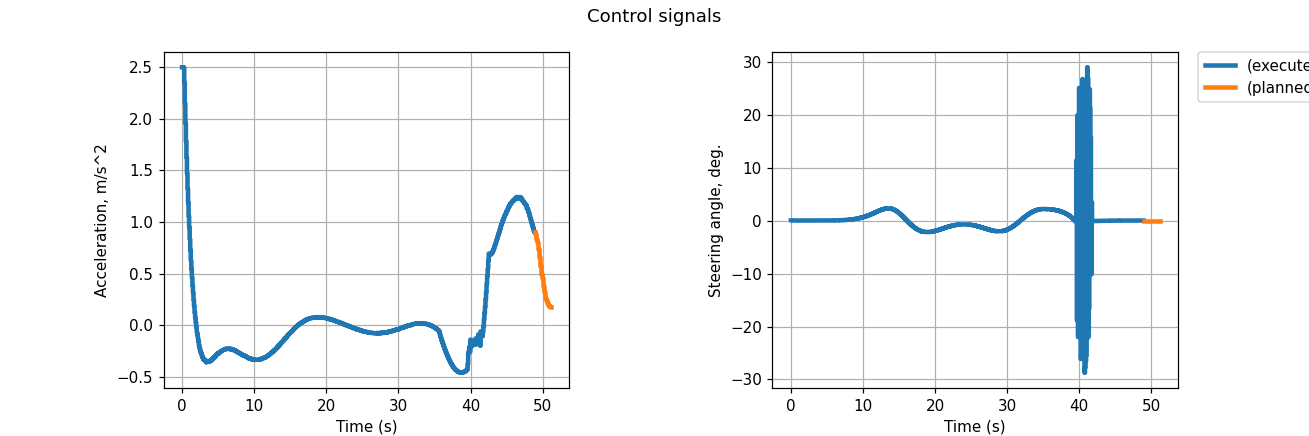

In [8]:
from KinematicBicycleCar import plot_u
u_plt, u_ax1, u_ax2 = plot_u(u_plan, mpcprob.u_opt, step, N)
plt.show()

## x-y plot of car's path
Arrows show velocity. Orange components are planned but not executed.

<IPython.core.display.Javascript object>


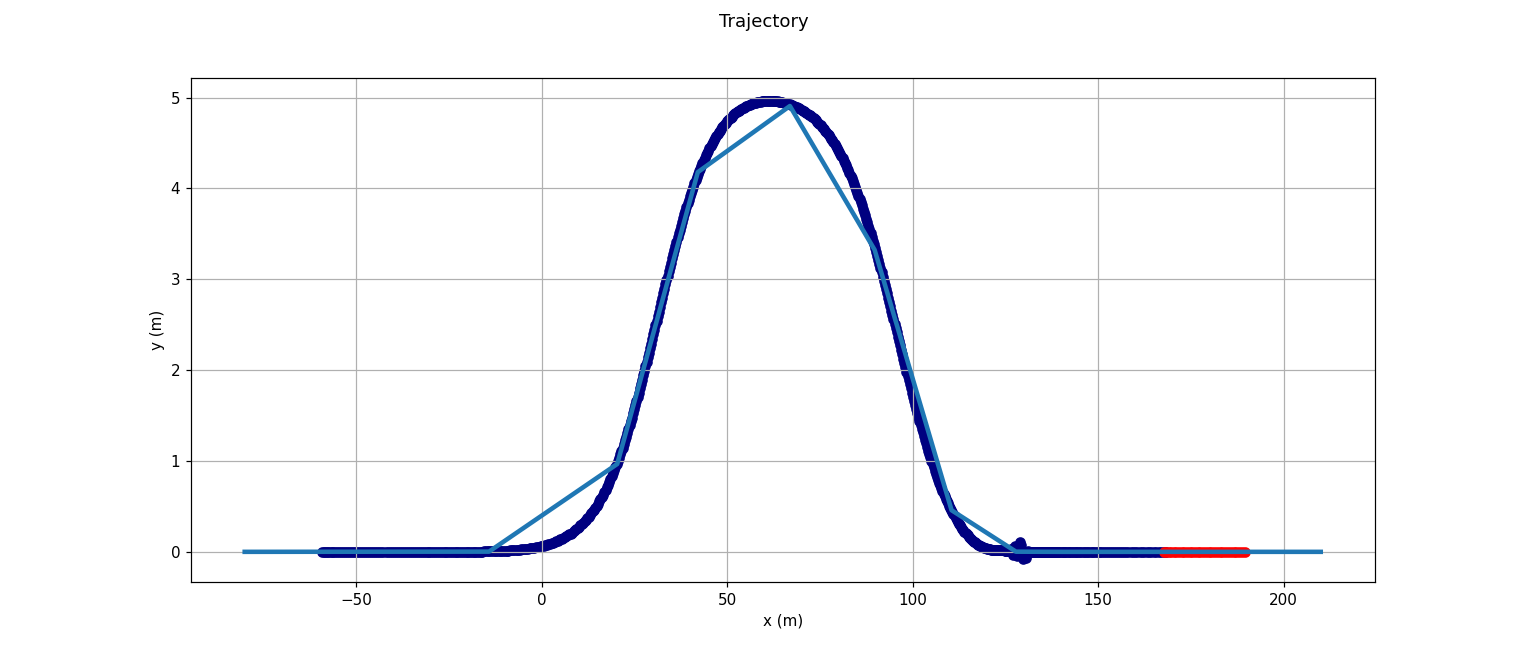

In [9]:
from KinematicBicycleCar import plot_x
x_plt, x_ax = plot_x(x_plan, mpcprob.x_opt, step, N)
    
roadrunner.plot(ax=x_ax)
plt.show()

## x vs time and y vs time, separately, with the boundaries

<IPython.core.display.Javascript object>


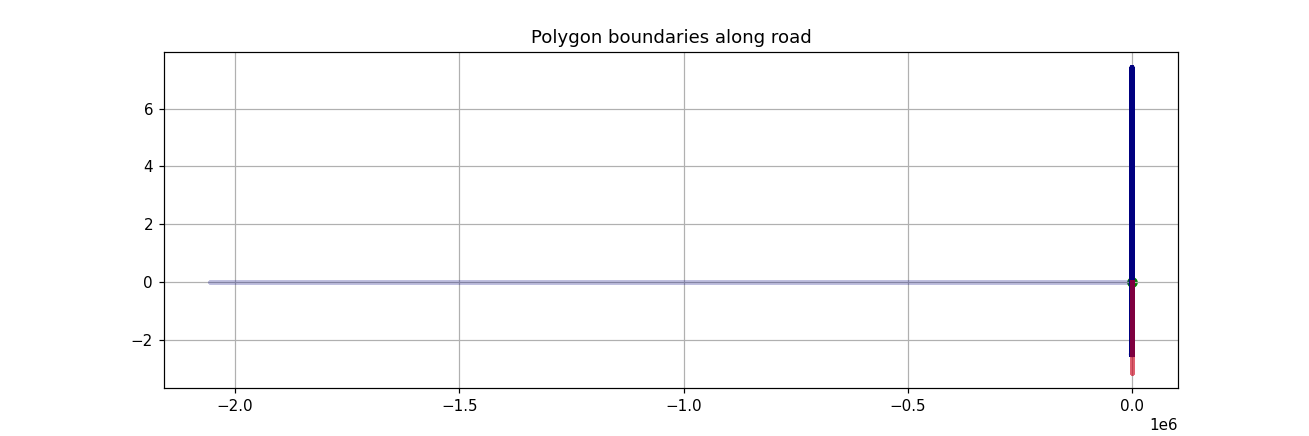

In [10]:
# Plot the road boundary as polygons
def plot_polygons(polygon_boundaries, ax=None):
    n_polys,_,_ = np.shape(polygon_boundaries)
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(12,4))
        
    for k in range(n_polys):
        # Plot the polygon fill
        ax.fill(polygon_boundaries[k,:,0], polygon_boundaries[k,:,1], "lightblue", alpha=0.1)
        # Plot the line around each polygon
        ax.plot(np.concatenate([polygon_boundaries[k,:,0],polygon_boundaries[k,0:1,0]]),
                np.concatenate([polygon_boundaries[k,:,1],polygon_boundaries[k,0:1,1]]),
                color="navy", alpha=0.25)

    # Plot the last polygon in RED
    ax.plot(np.concatenate([polygon_boundaries[-1,:,0],polygon_boundaries[-1,0:1,0]]),
            np.concatenate([polygon_boundaries[-1,:,1],polygon_boundaries[-1,0:1,1]]),
            color="red", alpha=0.5)
    return ax

ax = plot_polygons(polygon_boundaries)
ax.scatter(ic[0], ic[1], color="green")
plt.title("Polygon boundaries along road")
plt.show()

<IPython.core.display.Javascript object>


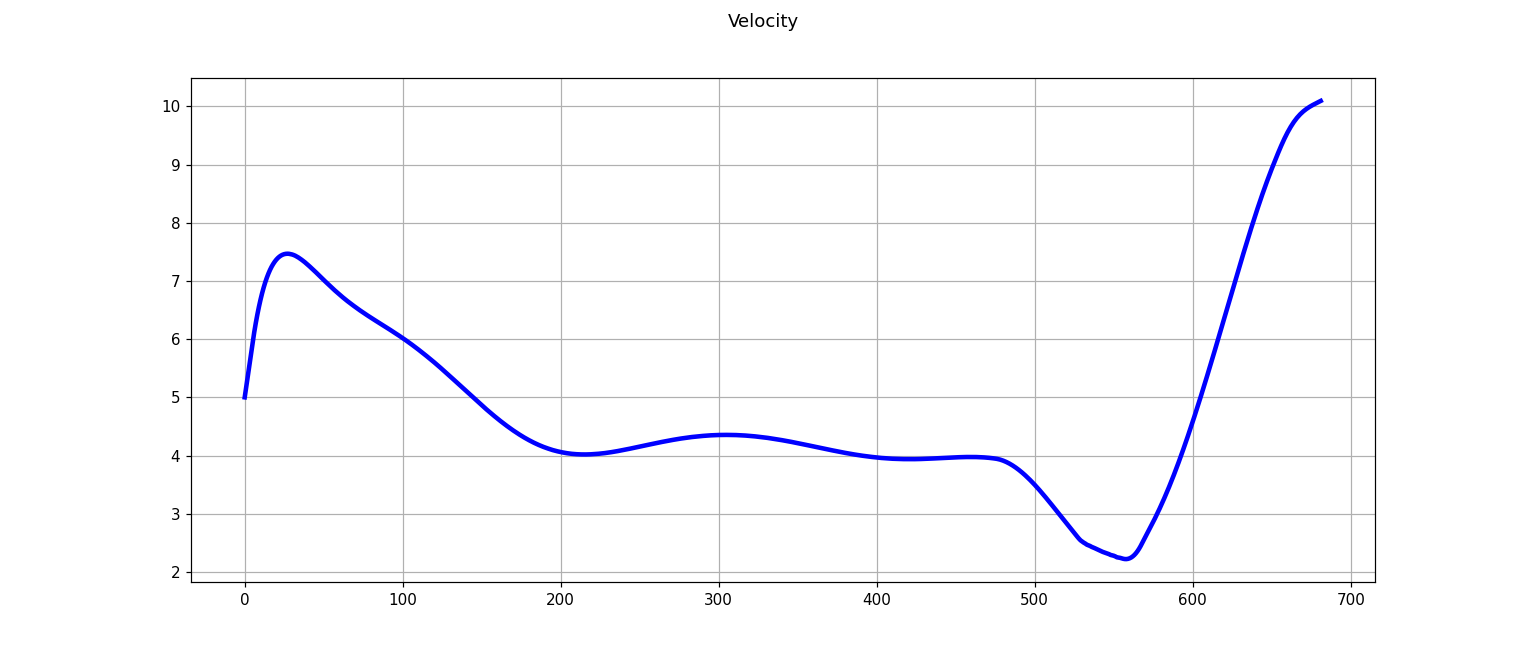

In [11]:
def plot_x(x_executed:np.array, x_planned:np.array):
    fig2, ax = plt.subplots(1,1,
        figsize=(14, 6))

    # Plot the last optimal path computed
    tgrid = np.linspace(0, mpcprob.model.T, mpcprob.model.N)
    vx_plan = np.multiply(x_planned[2],np.cos(x_planned[3]))
    vy_plan = np.multiply(x_planned[2],np.sin(x_planned[3]))

    # Plot the x given
    tgrid = np.linspace(0, mpcprob.model.T, len(x_executed[0]))
    vx_exec = np.multiply(x_executed[2],np.cos(x_executed[3]))
    vy_exec = np.multiply(x_executed[2],np.sin(x_executed[3]))
    # The first 2 states in the planned vector are also in the executed vector
    # since the first state is the initial state (the one we were at)
    # and the second one gets executed, therefore stored in the executed vector
    # to become the next run's initial state. This is why we slice vx_plan, vy_plan.
    vx = np.concatenate([vx_exec, vx_plan[2:]])
    vy = np.concatenate([vy_exec, vy_plan[2:]])
    ax.plot(np.sqrt(vx**2 + vy**2), color="blue")
    
    xs = np.concatenate([x_executed[0], x_planned[0,2:]])
    
    fig2.suptitle("Velocity")

    return fig2, ax
x_plt, x_ax = plot_x(x_plan, mpcprob.x_opt)
plt.show()